In [ ]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh import extract_features
from tsfresh.feature_extraction.feature_calculators import set_property
import pycatch22

from autogluon.tabular import TabularDataset, TabularPredictor

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split

import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

random_seed = 29

class_list = [
    'zero',
    'first',
    'second',
    'mm_1',
    'mm_2',
]

ag_model_root = './AutogluonModels/'
ag_model_norm_cat_s = TabularPredictor.load(os.path.join(ag_model_root, '5_class__s__best_quality__3h'))


## tsfresh featurization functions

In [3]:
@set_property("fctype", "combiner")
def catch22(x, param):
    """
    pycatch22

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: list of tuples (s, f) where s are the feature name in catch22, serialized as a string,
             and f the respective feature value as bool, int or float
    :return type: pandas.Series
    """
    data = pycatch22.catch22_all(x)

    return [(name, value) for name, value in zip(data['names'], data['values'])]

settings = ComprehensiveFCParameters()
settings[catch22] = None

def conc_points2raw_data(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    data_column = ['id']
    if 's' in sp_mode:
        for i in range(30):
            data_column += [f's{i}']
    if 'p' in sp_mode:
        for i in range(30):
            data_column += [f'p{i}']
    data = pd.DataFrame(columns=data_column)
    cnt = 0
    for idx in conc_points:
        data.loc[cnt, 'id'] = idx
        for i in range(30):
            if 's' in conc_points[idx]:
                data.loc[cnt, f's{i}'] = conc_points[idx]['s'][i]
            if 'p' in conc_points[idx]:
                data.loc[cnt, f'p{i}'] = conc_points[idx]['p'][i]
        cnt += 1
    return data


def preprocess_data_for_tsfresh(data:pd.DataFrame, sp_mode='sp')->pd.DataFrame:
    
    if sp_mode == 'sp':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    elif sp_mode == 's':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss

        return data_tsfresh
    
    elif sp_mode == 'p':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    else:
        raise ValueError('sp_mode can only be sp, s, or p')


def get_tsfresh_features(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    
    data = conc_points2raw_data(conc_points, sp_mode=sp_mode)
    data_tsfresh = preprocess_data_for_tsfresh(data, sp_mode=sp_mode)
    data_tsfresh = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_tsfresh['id'] = data_tsfresh.index
    data_tsfresh = data_tsfresh.reset_index(drop=True)
    # move id to the first column
    cols = list(data_tsfresh)
    cols.insert(0, cols.pop(cols.index('id')))
    data_tsfresh = data_tsfresh.loc[:, cols]
    return data_tsfresh

## data preprocess

In [4]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


def time_conc_curve_fit(time, conc, max_degree=3, verbose=False):

    for degree in range(1, max_degree+1):
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        time_poly = poly_features.fit_transform(time.reshape(-1, 1))

        # 多项式回归模型
        model = LinearRegression()
        model.fit(time_poly, conc)

        # 预测结果
        time_plot = time.reshape(-1, 1)
        time_plot_poly = poly_features.transform(time_plot)
        conc_plot = model.predict(time_plot_poly)

        mse = mean_squared_error(conc, conc_plot)
        if degree == 1:
            best_mse = mse
            best_degree = degree
            best_model = model
        else:
            if mse < best_mse:
                best_mse = mse
                best_degree = degree
                best_model = model
    if verbose:
        print('best degree:', best_degree)
        print('best mse:', best_mse)

    return best_model, best_degree

# def time_conc_curve_fit(time, conc, max_degree=10, refit=True, verbose=False):
#     pipeline = Pipeline([
#         ("poly_features", PolynomialFeatures()),
#         ("lin_reg", LinearRegression())
#     ])

#     parameters = {'poly_features__degree': range(1, max_degree+1)}

#     grid_search = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error', cv=5)
#     grid_search.fit(time.reshape(-1, 1), conc)
#     best_model = grid_search.best_estimator_
#     # 获取最佳次数
#     best_degree = grid_search.best_params_['poly_features__degree']

#     if verbose:
#         print(f"Best polynomial degree: {best_degree}")
#         print(f"Best model score (negative MSE): {grid_search.best_score_}")

#     # if refit:
#     #     best_model.fit(time.reshape(-1, 1), conc)
#     #     return best_model, best_degree
#     # else:
#     #     return best_model, best_degree
#     return best_model, best_degree


def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def judege_cat_eq(cat_eq):
    higher_cat_eq = 0.1
    norm_cat_eq = 0.01
    lower_cat_eq = 0.001
    if np.log10(cat_eq) >= np.log10(higher_cat_eq):
        return 'higher_cat'
    elif np.log10(cat_eq) >= np.log10(norm_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(norm_cat_eq)) > abs(np.log10(cat_eq) - np.log10(higher_cat_eq)):
            return 'higher_cat'
        else:
            return 'norm_cat'
    elif np.log10(cat_eq) >= np.log10(lower_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(lower_cat_eq)) > abs(np.log10(cat_eq) - np.log10(norm_cat_eq)):
            return 'norm_cat'
        else:
            return 'lower_cat'
    else:
        return 'lower_cat'
    

def is_quick_rxn(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    
    if obj == 's':
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c < conc_threshold: return True
            else: return False

    elif obj == 'p':
        conc_threshold = 1 - conc_threshold
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c > conc_threshold: return True
            else: return False


def cut_rxn_time(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    while is_quick_rxn(time, conc, obj=obj, time_threshold=time_threshold, conc_threshold=conc_threshold):
        time = normalize(time[:-1])
        conc = conc[:-1]
    return time, conc


def is_completed_rxn(conc, obj='s', conc_threshold=0.5):
        
        if obj == 's':
            for c in conc:
                if c < conc_threshold: return True
            return False
    
        elif obj == 'p':
            print('NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn')
            conc_threshold = 1 - conc_threshold
            for c in conc:
                if c > conc_threshold: return True
            return False
        

def cut_catalyst_init_rxn_time(time, conc, obj='s'):
    if obj == 's':
        while np.gradient(np.gradient(conc, time), time)[0] < 0:
            # print(np.gradient(np.gradient(conc, time), time))
            time = time[1:]
            conc = conc[1:]
        return conc
    elif obj == 'p':
        while np.gradient(np.gradient(conc, time), time)[0] > 0:
            # print(np.gradient(np.gradient(conc, time), time))
            time = time[1:]
            conc = conc[1:]
        return conc
    else:
        raise ValueError('obj can only be s or p')


def generate_time_conc_curve(
    time, 
    conc,
    max_degree=4,
    plot_fit_str: str | None = None, 
    verbose = False,
    fit=True,
):
    if fit:
        model, degree = time_conc_curve_fit(time, conc, max_degree=max_degree, verbose=verbose)
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = model.predict(PolynomialFeatures(degree=degree, include_bias=False).fit_transform(time_point.reshape(-1, 1)))
        # conc_point = model.predict(time_point.reshape(-1, 1))
        # conc_point = model.predict(time_point[1:-1].reshape(-1, 1))
        # conc_point = np.concatenate((conc[0:1], conc_point, conc[-1:]))
        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}')
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
        return time_point, conc_point
    else:
        # reserve 30 point averagely
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = np.interp(time_point, time, conc)
        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}')
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
        return time_point, conc_point

    
def get_top_x_probs(df, x=3):
    results = {}
    for i in range(1, x+1):
        results[f'list_indices_{i}'] = []
        results[f'list_probs_{i}'] = []
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        # Get the top x values and their indices
        top_x_values = row.nlargest(x).dropna().values
        top_x_indices = row.nlargest(x).index

        for i, (value, index) in enumerate(zip(top_x_values, top_x_indices)):
            # Append the index and value to the appropriate list
            results[f'list_indices_{i+1}'].append(index)
            results[f'list_probs_{i+1}'].append(value)
    
    return results

# Ye's Cases

## Ye

In [5]:
df_Ye = pd.read_csv('./experiments/Ye.csv')
df_Ye

time         S   catT  time.1       S.1  catT.1  time.2       S.2  \
0       0  0.199774  0.001       0  0.199111   0.001     0.0  0.199834   
1       1  0.196843  0.001       1  0.197738   0.001     1.0  0.198576   
2       2  0.195029  0.001       2  0.194434   0.001     2.0  0.196789   
3       3  0.192185  0.001       3  0.190820   0.001     3.0  0.197346   
4       4  0.190434  0.001       4  0.186185   0.001     4.0  0.191690   
..    ...       ...    ...     ...       ...     ...     ...       ...   
223   223  0.000268  0.001     223 -0.001781   0.001     NaN       NaN   
224   224  0.001566  0.001     224 -0.001089   0.001     NaN       NaN   
225   225  0.000319  0.001     225 -0.001173   0.001     NaN       NaN   
226   226  0.000423  0.001     226 -0.001776   0.001     NaN       NaN   
227   227 -0.000123  0.001     227 -0.000414   0.001     NaN       NaN   

     catT.2  time.3  ...  catT.12  time.13      S.13  catT.13  time.14  \
0     0.001     0.0  ...    0.005      0.0  0.200392    0.005      0.0   
1     0.001     1.0  ...    0.005      1.0  0.198946    0.005      1.0   
2     0.001     2.0  ...    0.005      2.0  0.196392    0.005      2.0   
3     0.001     3.0  ...    0.005      3.0  0.192915    0.005      3.0   
4     0.001     4.0  ...    0.005      4.0  0.188915    0.005      4.0   
..      ...     ...  ...      ...      ...       ...      ...      ...   
223     NaN     NaN  ...      NaN      NaN       NaN      NaN      NaN   
224     NaN     NaN  ...      NaN      NaN       NaN      NaN      NaN   
225     NaN     NaN  ...      NaN      NaN       NaN      NaN      NaN   
226     NaN     NaN  ...      NaN      NaN       NaN      NaN      NaN   
227     NaN     NaN  ...      NaN      NaN       NaN      NaN      NaN   

         S.14  catT.14  time.15      S.15  catT.15  
0    0.199342    0.005      0.0  0.200587    0.005  
1    0.195384    0.005      1.0  0.195617    0.005  
2    0.193619    0.005      2.0  0.193799    0.005  
3    0.190576    0.005      3.0  0.190547    0.005  
4    0.187661    0.005      4.0  0.186668    0.005  
..        ...      ...      ...       ...      ...  
223       NaN      NaN      NaN       NaN      NaN  
224       NaN      NaN      NaN       NaN      NaN  
225       NaN      NaN      NaN       NaN      NaN  
226       NaN      NaN      NaN       NaN      NaN  
227       NaN      NaN      NaN       NaN      NaN  

[228 rows x 48 columns]

In [6]:
# only S
sp_mode = 's'

time_1 = normalize(df_Ye['time'].dropna().values)
s_conc_1 = df_Ye['S'].dropna().values/df_Ye['S'].dropna().values[0]

time_2 = normalize(df_Ye['time.1'].dropna().values)
s_conc_2 = df_Ye['S.1'].dropna().values/df_Ye['S.1'].dropna().values[0]

time_3 = normalize(df_Ye['time.2'].dropna().values)
s_conc_3 = df_Ye['S.2'].dropna().values/df_Ye['S.2'].dropna().values[0]

time_4 = normalize(df_Ye['time.3'].dropna().values)
s_conc_4 = df_Ye['S.3'].dropna().values/df_Ye['S.3'].dropna().values[0]

time_5 = normalize(df_Ye['time.4'].dropna().values)
s_conc_5 = df_Ye['S.4'].dropna().values/df_Ye['S.4'].dropna().values[0]

time_6 = normalize(df_Ye['time.5'].dropna().values)
s_conc_6 = df_Ye['S.5'].dropna().values/df_Ye['S.5'].dropna().values[0]

time_7 = normalize(df_Ye['time.6'].dropna().values)
s_conc_7 = df_Ye['S.6'].dropna().values/df_Ye['S.6'].dropna().values[0]

time_8 = normalize(df_Ye['time.7'].dropna().values)
s_conc_8 = df_Ye['S.7'].dropna().values/df_Ye['S.7'].dropna().values[0]

time_9 = normalize(df_Ye['time.8'].dropna().values)
s_conc_9 = df_Ye['S.8'].dropna().values/df_Ye['S.8'].dropna().values[0]

time_10 = normalize(df_Ye['time.9'].dropna().values)
s_conc_10 = df_Ye['S.9'].dropna().values/df_Ye['S.9'].dropna().values[0]

time_11 = normalize(df_Ye['time.10'].dropna().values)
s_conc_11 = df_Ye['S.10'].dropna().values/df_Ye['S.10'].dropna().values[0]

time_12 = normalize(df_Ye['time.11'].dropna().values)
s_conc_12 = df_Ye['S.11'].dropna().values/df_Ye['S.11'].dropna().values[0]

time_13 = normalize(df_Ye['time.12'].dropna().values)
s_conc_13 = df_Ye['S.12'].dropna().values/df_Ye['S.12'].dropna().values[0]

time_14 = normalize(df_Ye['time.13'].dropna().values)
s_conc_14 = df_Ye['S.13'].dropna().values/df_Ye['S.13'].dropna().values[0]

time_15 = normalize(df_Ye['time.14'].dropna().values)
s_conc_15 = df_Ye['S.14'].dropna().values/df_Ye['S.14'].dropna().values[0]

time_16 = normalize(df_Ye['time.15'].dropna().values)
s_conc_16 = df_Ye['S.15'].dropna().values/df_Ye['S.15'].dropna().values[0]

In [7]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

print('====================')

if is_quick_rxn(time_4, s_conc_4, obj='s'):
    print('need to cut time_4')
    time_4, s_conc_4 = cut_rxn_time(time_4, s_conc_4, obj='s')
else:
    print('time_4 is fine')
if is_completed_rxn(s_conc_4, obj='s'):
    print('rxn_4 is completed')
else:
    print('rxn_4 may be not completed')

print('====================')

if is_quick_rxn(time_5, s_conc_5, obj='s'):
    print('need to cut time_5')
    time_5, s_conc_5 = cut_rxn_time(time_5, s_conc_5, obj='s')
else:
    print('time_5 is fine')
if is_completed_rxn(s_conc_5, obj='s'):
    print('rxn_5 is completed')
else:
    print('rxn_5 may be not completed')

print('====================')

if is_quick_rxn(time_6, s_conc_6, obj='s'):
    print('need to cut time_6')
    time_6, s_conc_6 = cut_rxn_time(time_6, s_conc_6, obj='s')
else:
    print('time_6 is fine')
if is_completed_rxn(s_conc_6, obj='s'):
    print('rxn_6 is completed')
else:
    print('rxn_6 may be not completed')

print('====================')

if is_quick_rxn(time_7, s_conc_7, obj='s'):
    print('need to cut time_7')
    time_7, s_conc_7 = cut_rxn_time(time_7, s_conc_7, obj='s')
else:
    print('time_7 is fine')
if is_completed_rxn(s_conc_7, obj='s'):
    print('rxn_7 is completed')
else:
    print('rxn_7 may be not completed')

print('====================')

if is_quick_rxn(time_8, s_conc_8, obj='s'):
    print('need to cut time_8')
    time_8, s_conc_8 = cut_rxn_time(time_8, s_conc_8, obj='s')
else:
    print('time_8 is fine')
if is_completed_rxn(s_conc_8, obj='s'):
    print('rxn_8 is completed')
else:
    print('rxn_8 may be not completed')

print('====================')

if is_quick_rxn(time_9, s_conc_9, obj='s'):
    print('need to cut time_9')
    time_9, s_conc_9 = cut_rxn_time(time_9, s_conc_9, obj='s')
else:
    print('time_9 is fine')
if is_completed_rxn(s_conc_9, obj='s'):
    print('rxn_9 is completed')
else:
    print('rxn_9 may be not completed')

print('====================')

if is_quick_rxn(time_10, s_conc_10, obj='s'):
    print('need to cut time_10')
    time_10, s_conc_10 = cut_rxn_time(time_10, s_conc_10, obj='s')
else:
    print('time_10 is fine')
if is_completed_rxn(s_conc_10, obj='s'):
    print('rxn_10 is completed')
else:
    print('rxn_10 may be not completed')

print('====================')

if is_quick_rxn(time_11, s_conc_11, obj='s'):
    print('need to cut time_11')
    time_11, s_conc_11 = cut_rxn_time(time_11, s_conc_11, obj='s')
else:
    print('time_11 is fine')
if is_completed_rxn(s_conc_11, obj='s'):
    print('rxn_11 is completed')
else:
    print('rxn_11 may be not completed')

print('====================')

if is_quick_rxn(time_12, s_conc_12, obj='s'):
    print('need to cut time_12')
    time_12, s_conc_12 = cut_rxn_time(time_12, s_conc_12, obj='s')
else:
    print('time_12 is fine')
if is_completed_rxn(s_conc_12, obj='s'):
    print('rxn_12 is completed')
else:
    print('rxn_12 may be not completed')

print('====================')

if is_quick_rxn(time_13, s_conc_13, obj='s'):
    print('need to cut time_13')
    time_13, s_conc_13 = cut_rxn_time(time_13, s_conc_13, obj='s')
else:
    print('time_13 is fine')
if is_completed_rxn(s_conc_13, obj='s'):
    print('rxn_13 is completed')
else:
    print('rxn_13 may be not completed')

print('====================')

if is_quick_rxn(time_14, s_conc_14, obj='s'):
    print('need to cut time_14')
    time_14, s_conc_14 = cut_rxn_time(time_14, s_conc_14, obj='s')
else:
    print('time_14 is fine')
if is_completed_rxn(s_conc_14, obj='s'):
    print('rxn_14 is completed')
else:
    print('rxn_14 may be not completed')

print('====================')

if is_quick_rxn(time_15, s_conc_15, obj='s'):
    print('need to cut time_15')
    time_15, s_conc_15 = cut_rxn_time(time_15, s_conc_15, obj='s')
else:
    print('time_15 is fine')
if is_completed_rxn(s_conc_15, obj='s'):
    print('rxn_15 is completed')
else:
    print('rxn_15 may be not completed')

print('====================')

if is_quick_rxn(time_16, s_conc_16, obj='s'):
    print('need to cut time_16')
    time_16, s_conc_16 = cut_rxn_time(time_16, s_conc_16, obj='s')
else:
    print('time_16 is fine')
if is_completed_rxn(s_conc_16, obj='s'):
    print('rxn_16 is completed')
else:
    print('rxn_16 may be not completed')
    

time_1 is fine
rxn_1 is completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed
time_4 is fine
rxn_4 is completed
time_5 is fine
rxn_5 is completed
time_6 is fine
rxn_6 is completed
time_7 is fine
rxn_7 is completed
time_8 is fine
rxn_8 is completed
time_9 is fine
rxn_9 is completed
time_10 is fine
rxn_10 is completed
time_11 is fine
rxn_11 is completed
time_12 is fine
rxn_12 is completed
time_13 is fine
rxn_13 is completed
time_14 is fine
rxn_14 is completed
time_15 is fine
rxn_15 is completed
time_16 is fine
rxn_16 is completed


In [8]:
max_degree = 6
fit = True

best degree: 6
best mse: 4.296252371786766e-05
best degree: 6
best mse: 4.054820529445103e-05
best degree: 6
best mse: 2.0166256036198546e-05


Text(0.5, 1.0, 'cat 0.005 e.q.')

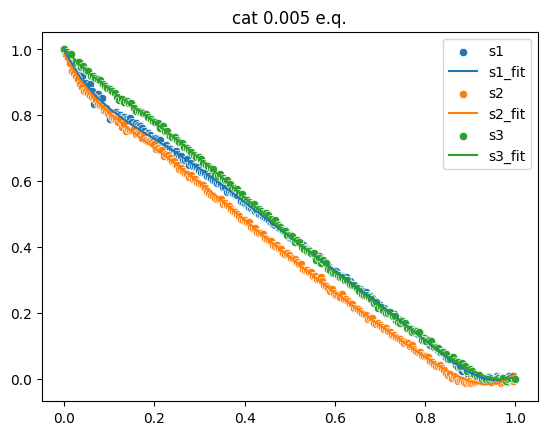

In [9]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=max_degree, plot_fit_str='s1', verbose=True,
                                                        fit=fit
                                                        )
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=max_degree, plot_fit_str='s2', verbose=True,
                                                        fit=fit
                                                        )
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=max_degree, plot_fit_str='s3', verbose=True,
                                                        fit=fit
                                                        )
plt.title('cat 0.005 e.q.')

best degree: 6
best mse: 2.1601568748788732e-05
best degree: 6
best mse: 1.1027634026983914e-05
best degree: 6
best mse: 1.2255439687047302e-05


Text(0.5, 1.0, 'cat 0.01 e.q.')

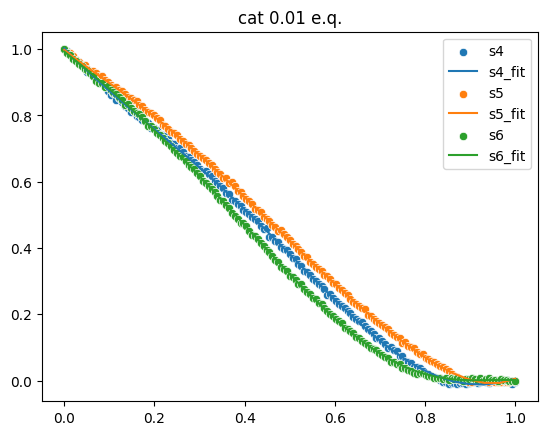

In [10]:
time_point_4, s_conc_point_4 = generate_time_conc_curve(time_4, s_conc_4, max_degree=max_degree, plot_fit_str='s4', verbose=True,
                                                        fit=fit
                                                        )
time_point_5, s_conc_point_5 = generate_time_conc_curve(time_5, s_conc_5, max_degree=max_degree, plot_fit_str='s5', verbose=True,
                                                        fit=fit
                                                        )
time_point_6, s_conc_point_6 = generate_time_conc_curve(time_6, s_conc_6, max_degree=max_degree, plot_fit_str='s6', verbose=True,
                                                        fit=fit
                                                        )
plt.title('cat 0.01 e.q.')

best degree: 6
best mse: 5.282462191534755e-05
best degree: 6
best mse: 0.00012117420080170254
best degree: 6
best mse: 5.798482962526785e-05


Text(0.5, 1.0, 'cat 0.015 e.q.')

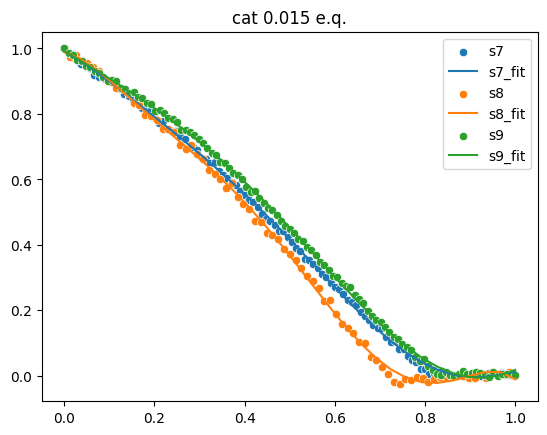

In [11]:
time_point_7, s_conc_point_7 = generate_time_conc_curve(time_7, s_conc_7, max_degree=max_degree, plot_fit_str='s7', verbose=True,
                                                        fit=fit
                                                        )
time_point_8, s_conc_point_8 = generate_time_conc_curve(time_8, s_conc_8, max_degree=max_degree, plot_fit_str='s8', verbose=True,
                                                        fit=fit
                                                        )
time_point_9, s_conc_point_9 = generate_time_conc_curve(time_9, s_conc_9, max_degree=max_degree, plot_fit_str='s9', verbose=True,
                                                        fit=fit
                                                        )
plt.title('cat 0.015 e.q.')

best degree: 6
best mse: 5.504255633606277e-05
best degree: 6
best mse: 8.971243668834801e-05
best degree: 6
best mse: 1.855647919572195e-05


Text(0.5, 1.0, 'cat 0.02 e.q.')

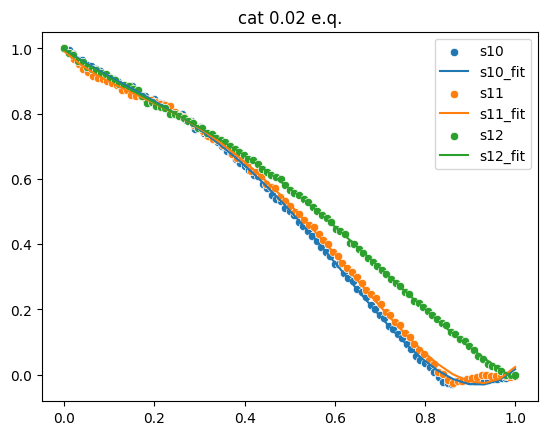

In [12]:
time_point_10, s_conc_point_10 = generate_time_conc_curve(time_10, s_conc_10, max_degree=max_degree, plot_fit_str='s10', verbose=True,
                                                          fit=fit
                                                          )
time_point_11, s_conc_point_11 = generate_time_conc_curve(time_11, s_conc_11, max_degree=max_degree, plot_fit_str='s11', verbose=True,
                                                          fit=fit
                                                          )
time_point_12, s_conc_point_12 = generate_time_conc_curve(time_12, s_conc_12, max_degree=max_degree, plot_fit_str='s12', verbose=True,
                                                          fit=fit
                                                          )
plt.title('cat 0.02 e.q.')

best degree: 6
best mse: 1.3119260120316623e-05
best degree: 6
best mse: 1.9666645097242708e-05
best degree: 6
best mse: 1.8770885967343202e-05
best degree: 6
best mse: 1.2306086678429061e-05


Text(0.5, 1.0, 'cat 0.025 e.q.')

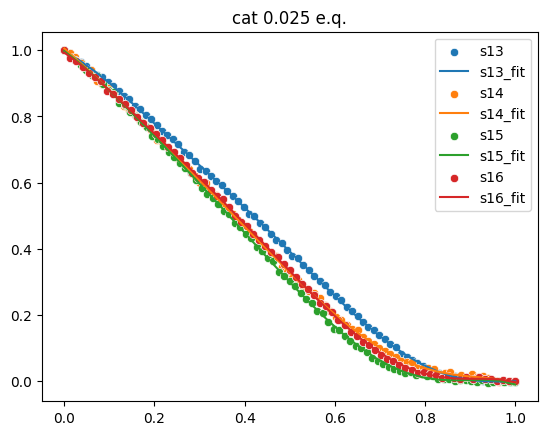

In [13]:
time_point_13, s_conc_point_13 = generate_time_conc_curve(time_13, s_conc_13, max_degree=max_degree, plot_fit_str='s13', verbose=True,
                                                          fit=fit
                                                          )
time_point_14, s_conc_point_14 = generate_time_conc_curve(time_14, s_conc_14, max_degree=max_degree, plot_fit_str='s14', verbose=True,
                                                          fit=fit
                                                          )
time_point_15, s_conc_point_15 = generate_time_conc_curve(time_15, s_conc_15, max_degree=max_degree, plot_fit_str='s15', verbose=True,
                                                          fit=fit
                                                          )
time_point_16, s_conc_point_16 = generate_time_conc_curve(time_16, s_conc_16, max_degree=max_degree, plot_fit_str='s16', verbose=True,
                                                          fit=fit
                                                          )
plt.title('cat 0.025 e.q.')

In [14]:
# featurize

df_Ye_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'Ye_rxn_1': {'s': s_conc_point_1},
        'Ye_rxn_2': {'s': s_conc_point_2},
        'Ye_rxn_3': {'s': s_conc_point_3},
        'Ye_rxn_4': {'s': s_conc_point_4},
        'Ye_rxn_5': {'s': s_conc_point_5},
        'Ye_rxn_6': {'s': s_conc_point_6},
        'Ye_rxn_7': {'s': s_conc_point_7},
        'Ye_rxn_8': {'s': s_conc_point_8},
        'Ye_rxn_9': {'s': s_conc_point_9},
        'Ye_rxn_10': {'s': s_conc_point_10},
        'Ye_rxn_11': {'s': s_conc_point_11},
        'Ye_rxn_12': {'s': s_conc_point_12},
        'Ye_rxn_13': {'s': s_conc_point_13},
        'Ye_rxn_14': {'s': s_conc_point_14},
        'Ye_rxn_15': {'s': s_conc_point_15},
        'Ye_rxn_16': {'s': s_conc_point_16}
    },
    sp_mode = sp_mode
)

df_Ye_raw_data = conc_points2raw_data(
    conc_points = {
        'Ye_rxn_1': {'s': s_conc_point_1},
        'Ye_rxn_2': {'s': s_conc_point_2},
        'Ye_rxn_3': {'s': s_conc_point_3},
        'Ye_rxn_4': {'s': s_conc_point_4},
        'Ye_rxn_5': {'s': s_conc_point_5},
        'Ye_rxn_6': {'s': s_conc_point_6},
        'Ye_rxn_7': {'s': s_conc_point_7},
        'Ye_rxn_8': {'s': s_conc_point_8},
        'Ye_rxn_9': {'s': s_conc_point_9},
        'Ye_rxn_10': {'s': s_conc_point_10},
        'Ye_rxn_11': {'s': s_conc_point_11},
        'Ye_rxn_12': {'s': s_conc_point_12},
        'Ye_rxn_13': {'s': s_conc_point_13},
        'Ye_rxn_14': {'s': s_conc_point_14},
        'Ye_rxn_15': {'s': s_conc_point_15},
        'Ye_rxn_16': {'s': s_conc_point_16}
    },
    sp_mode = sp_mode
)
df_Ye_data = pd.merge(df_Ye_tsfresh_data, df_Ye_raw_data, on='id')
df_Ye_data

Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 281.31it/s]


id  s__variance_larger_than_standard_deviation  \
0    Ye_rxn_1                                         0.0   
1   Ye_rxn_10                                         0.0   
2   Ye_rxn_11                                         0.0   
3   Ye_rxn_12                                         0.0   
4   Ye_rxn_13                                         0.0   
5   Ye_rxn_14                                         0.0   
6   Ye_rxn_15                                         0.0   
7   Ye_rxn_16                                         0.0   
8    Ye_rxn_2                                         0.0   
9    Ye_rxn_3                                         0.0   
10   Ye_rxn_4                                         0.0   
11   Ye_rxn_5                                         0.0   
12   Ye_rxn_6                                         0.0   
13   Ye_rxn_7                                         0.0   
14   Ye_rxn_8                                         0.0   
15   Ye_rxn_9                                         0.0   

    s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                    0.0                   0.0               0.0   
1                    0.0                   0.0               0.0   
2                    0.0                   0.0               0.0   
3                    0.0                   0.0               0.0   
4                    0.0                   0.0               0.0   
5                    0.0                   0.0               0.0   
6                    0.0                   0.0               0.0   
7                    0.0                   0.0               0.0   
8                    0.0                   0.0               0.0   
9                    0.0                   0.0               0.0   
10                   0.0                   0.0               0.0   
11                   0.0                   0.0               0.0   
12                   0.0                   0.0               0.0   
13                   0.0                   0.0               0.0   
14                   0.0                   0.0               0.0   
15                   0.0                   0.0               0.0   

    s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0       13.028070       8.362098            0.035174       -0.033867   
1       14.070536      10.377194            0.037026       -0.033799   
2       14.347409      10.427210            0.036786       -0.033373   
3       15.861228      11.276686            0.034796       -0.034796   
4       12.630229       8.739773            0.034336       -0.034279   
5       11.742084       7.930518            0.034813       -0.034813   
6       11.210786       7.691674            0.034839       -0.034724   
7       11.668906       7.952581            0.034353       -0.034339   
8       11.829116       7.481858            0.035640       -0.033481   
9       13.513039       9.104471            0.034895       -0.034503   
10      12.234778       8.391155            0.035546       -0.034375   
11      13.185378       9.159997            0.035077       -0.034225   
12      11.571510       7.932285            0.034249       -0.034171   
13      12.884120       9.039436            0.034823       -0.033711   
14      11.954359       8.623790            0.036807       -0.034464   
15      13.509821       9.649321            0.035266       -0.033601   

    s__mean_second_derivative_central  ...       s20       s21       s22  \
0                            0.001750  ...   0.23646  0.199619  0.161833   
1                            0.001113  ...  0.196088  0.142633  0.093235   
2                            0.001356  ...  0.226522  0.172619  0.121354   
3                            0.000031  ...   0.34108  0.296708  0.252492   
4                            0.000473  ...   0.14749    0.1107  0.078343   
5                            0.000572  ...  0.110083  0.082427  0.059696   
6                            0.000459  ...  0.070997  0.045

In [15]:
# predict
Ye_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_Ye_data)
# Ye_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_Ye_data)
# Ye_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_Ye_data)

In [173]:
# # with fit max_degree=4
# df_Ye_pred_results = pd.DataFrame({
#     'id': df_Ye_data['id'],
#     'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
#     'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
#     'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
#     'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
#     'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
#     'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
#     # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
#     # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
#     # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
#     # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
#     # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
#     # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
#     # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
#     # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
#     # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
#     # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
#     # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
#     # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
# })
# df_Ye_pred_results = df_Ye_pred_results.round(3)
# df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
# df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1     mm_1           0.320    first           0.292     mm_2   
1    Ye_rxn_2    first           0.654     mm_2           0.107     mm_1   
2    Ye_rxn_3     mm_1           0.702     zero           0.107   second   
3    Ye_rxn_4     mm_1           0.491     zero           0.295   second   
4    Ye_rxn_5     zero           0.657     mm_1           0.141   second   
5    Ye_rxn_6     zero           0.589     mm_1           0.211   second   
6    Ye_rxn_7     zero           0.692     mm_1           0.113   second   
7    Ye_rxn_8     zero           0.684     mm_1           0.125   second   
8    Ye_rxn_9     zero           0.716     mm_1           0.098   second   
9   Ye_rxn_10     zero           0.728     mm_1           0.088   second   
10  Ye_rxn_11     zero           0.735     mm_1           0.081   second   
11  Ye_rxn_12     zero           0.663     mm_1           0.137   second   
12  Ye_rxn_13     zero           0.537     mm_1           0.260   second   
13  Ye_rxn_14     mm_1           0.737     zero           0.077     mm_2   
14  Ye_rxn_15     zero           0.488     mm_1           0.298   second   
15  Ye_rxn_16     mm_1           0.392     zero           0.392   second   

    pred_3rd_proba  
0            0.190  
1            0.102  
2            0.064  
3            0.072  
4            0.067  
5            0.067  
6            0.065  
7            0.064  
8            0.062  
9            0.062  
10           0.061  
11           0.067  
12           0.068  
13           0.062  
14           0.072  
15           0.072

#### key data!! Ye_rxn_14	mm_1	0.729	zero	0.082	mm_2	0.063
mm_1 0.729 -> 0.727

In [182]:
# previous with random seed 42
# with fit max_degree=6
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results = df_Ye_pred_results.round(3)
df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1    first           0.480     mm_1           0.185     mm_2   
1    Ye_rxn_2    first           0.698     mm_1           0.088     mm_2   
2    Ye_rxn_3     mm_1           0.524     zero           0.258     mm_2   
3    Ye_rxn_4     mm_1           0.442     zero           0.340     mm_2   
4    Ye_rxn_5     zero           0.676     mm_1           0.124   second   
5    Ye_rxn_6     zero           0.477     mm_1           0.311   second   
6    Ye_rxn_7     zero           0.707     mm_1           0.103   second   
7    Ye_rxn_8     zero           0.738     mm_1           0.079   second   
8    Ye_rxn_9     zero           0.721     mm_1           0.093   second   
9   Ye_rxn_10     zero           0.734     mm_1           0.082   second   
10  Ye_rxn_11     zero           0.738     mm_1           0.078   second   
11  Ye_rxn_12     zero           0.666     mm_1           0.133   second   
12  Ye_rxn_13     zero           0.695     mm_1           0.116   second   
13  Ye_rxn_14     mm_1           0.729     zero           0.082     mm_2   
14  Ye_rxn_15     zero           0.473     mm_1           0.318   second   
15  Ye_rxn_16     zero           0.488     mm_1           0.298   second   

    pred_3rd_proba  
0            0.145  
1            0.084  
2            0.073  
3            0.073  
4            0.067  
5            0.071  
6            0.063  
7            0.061  
8            0.062  
9            0.062  
10           0.061  
11           0.067  
12           0.063  
13           0.063  
14           0.070  
15           0.071

In [16]:
# latest with random seed 29
# with fit max_degree=6
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results = df_Ye_pred_results.round(3)
df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1    first           0.354     mm_1           0.266     zero   
1    Ye_rxn_2    first           0.678     mm_1           0.103     mm_2   
2    Ye_rxn_3     mm_1           0.501     zero           0.312   second   
3    Ye_rxn_4     zero           0.583     mm_1           0.233   second   
4    Ye_rxn_5     zero           0.659     mm_1           0.159   second   
5    Ye_rxn_6     zero           0.418     mm_1           0.389   second   
6    Ye_rxn_7     zero           0.709     mm_1           0.117   second   
7    Ye_rxn_8     zero           0.706     mm_1           0.114     mm_2   
8    Ye_rxn_9     zero           0.689     mm_1           0.133     mm_2   
9   Ye_rxn_10     zero           0.688     mm_1           0.129     mm_2   
10  Ye_rxn_11     zero           0.685     mm_1           0.130     mm_2   
11  Ye_rxn_12     zero           0.620     mm_1           0.191   second   
12  Ye_rxn_13     zero           0.647     mm_1           0.172    first   
13  Ye_rxn_14     mm_1           0.727     zero           0.094    first   
14  Ye_rxn_15     mm_1           0.418     zero           0.389     mm_2   
15  Ye_rxn_16     zero           0.419     mm_1           0.390   second   

    pred_3rd_proba  
0            0.179  
1            0.091  
2            0.062  
3            0.061  
4            0.061  
5            0.064  
6            0.058  
7            0.061  
8            0.060  
9            0.062  
10           0.062  
11           0.063  
12           0.061  
13           0.060  
14           0.065  
15           0.064

In [18]:
# latest with random seed 29
# with fit max_degree=6
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_probs_5'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results = df_Ye_pred_results.round(5)
df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1    first         0.35415     mm_1         0.26604     zero   
1    Ye_rxn_2    first         0.67754     mm_1         0.10279     mm_2   
2    Ye_rxn_3     mm_1         0.50123     zero         0.31171   second   
3    Ye_rxn_4     zero         0.58319     mm_1         0.23307   second   
4    Ye_rxn_5     zero         0.65887     mm_1         0.15900   second   
5    Ye_rxn_6     zero         0.41839     mm_1         0.38940   second   
6    Ye_rxn_7     zero         0.70871     mm_1         0.11674   second   
7    Ye_rxn_8     zero         0.70602     mm_1         0.11371     mm_2   
8    Ye_rxn_9     zero         0.68874     mm_1         0.13306     mm_2   
9   Ye_rxn_10     zero         0.68775     mm_1         0.12913     mm_2   
10  Ye_rxn_11     zero         0.68458     mm_1         0.13024     mm_2   
11  Ye_rxn_12     zero         0.61975     mm_1         0.19088   second   
12  Ye_rxn_13     zero         0.64716     mm_1         0.17172    first   
13  Ye_rxn_14     mm_1         0.72696     zero         0.09412    first   
14  Ye_rxn_15     mm_1         0.41793     zero         0.38856     mm_2   
15  Ye_rxn_16     zero         0.41947     mm_1         0.38980   second   

    pred_3rd_proba pred_4th  pred_4th_proba pred_5th  pred_5th_proba  
0          0.17912     mm_2         0.10946   second         0.09123  
1          0.09082   second         0.06681     zero         0.06204  
2          0.06242     mm_2         0.06241    first         0.06224  
3          0.06130     mm_2         0.06129    first         0.06115  
4          0.06077     mm_2         0.06075    first         0.06061  
5          0.06413     mm_2         0.06412    first         0.06396  
6          0.05824     mm_2         0.05822    first         0.05809  
7          0.06080    first         0.05999   second         0.05948  
8          0.06019   second         0.05928    first         0.05872  
9          0.06199   second         0.06065    first         0.06048  
10         0.06238   second         0.06203    first         0.06076  
11         0.06318     mm_2         0.06316    first         0.06302  
12         0.06071   second         0.06021     mm_2         0.06020  
13         0.06043     mm_2         0.05925   second         0.05924  
14         0.06457   second         0.06455    first         0.06439  
15         0.06363     mm_2         0.06363    first         0.06346

In [146]:
# with fit max_degree=8
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results = df_Ye_pred_results.round(3)
df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1    first           0.469     mm_1           0.195     mm_2   
1    Ye_rxn_2    first           0.701     mm_2           0.084     mm_1   
2    Ye_rxn_3     mm_1           0.515     zero           0.263     mm_2   
3    Ye_rxn_4     zero           0.414     mm_1           0.373   second   
4    Ye_rxn_5     zero           0.672     mm_1           0.127   second   
5    Ye_rxn_6     zero           0.511     mm_1           0.280   second   
6    Ye_rxn_7     zero           0.722     mm_1           0.090   second   
7    Ye_rxn_8     zero           0.732     mm_1           0.084   second   
8    Ye_rxn_9     zero           0.732     mm_1           0.084   second   
9   Ye_rxn_10     zero           0.737     mm_1           0.080   second   
10  Ye_rxn_11     zero           0.738     mm_1           0.078   second   
11  Ye_rxn_12     zero           0.744     mm_1           0.073   second   
12  Ye_rxn_13     zero           0.613     mm_1           0.181   second   
13  Ye_rxn_14     mm_1           0.732     zero           0.080     mm_2   
14  Ye_rxn_15     zero           0.543     mm_1           0.253   second   
15  Ye_rxn_16     zero           0.511     mm_1           0.285   second   

    pred_3rd_proba  
0            0.144  
1            0.084  
2            0.074  
3            0.071  
4            0.067  
5            0.070  
6            0.063  
7            0.062  
8            0.062  
9            0.061  
10           0.061  
11           0.061  
12           0.069  
13           0.063  
14           0.068  
15           0.068

In [155]:
# with fit max_degree=10
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results = df_Ye_pred_results.round(3)
df_Ye_pred_results = df_Ye_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_Ye_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0    Ye_rxn_1    first           0.470     mm_1           0.183     mm_2   
1    Ye_rxn_2    first           0.714     mm_2           0.082     mm_1   
2    Ye_rxn_3     mm_1           0.449     zero           0.330     mm_2   
3    Ye_rxn_4     mm_1           0.403     zero           0.381     mm_2   
4    Ye_rxn_5     zero           0.680     mm_1           0.122   second   
5    Ye_rxn_6     zero           0.514     mm_1           0.276   second   
6    Ye_rxn_7     zero           0.744     mm_1           0.073   second   
7    Ye_rxn_8     zero           0.745     mm_1           0.072   second   
8    Ye_rxn_9     zero           0.742     mm_1           0.075   second   
9   Ye_rxn_10     zero           0.743     mm_1           0.073   second   
10  Ye_rxn_11     zero           0.736     mm_1           0.079   second   
11  Ye_rxn_12     zero           0.745     mm_1           0.072   second   
12  Ye_rxn_13     zero           0.623     mm_1           0.173   second   
13  Ye_rxn_14     mm_1           0.737     zero           0.077     mm_2   
14  Ye_rxn_15     zero           0.554     mm_1           0.242   second   
15  Ye_rxn_16     mm_1           0.567     zero           0.229   second   

    pred_3rd_proba  
0            0.148  
1            0.076  
2            0.074  
3            0.072  
4            0.066  
5            0.070  
6            0.061  
7            0.061  
8            0.061  
9            0.061  
10           0.062  
11           0.061  
12           0.068  
13           0.062  
14           0.068  
15           0.068

In [164]:
# with fit max_degree=12
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0    Ye_rxn_1             first                 0.428718              mm_1   
1   Ye_rxn_10              zero                 0.742972              mm_1   
2   Ye_rxn_11              zero                 0.736124              mm_1   
3   Ye_rxn_12              zero                 0.743840              mm_1   
4   Ye_rxn_13              zero                 0.622362              mm_1   
5   Ye_rxn_14              mm_1                 0.686218              zero   
6   Ye_rxn_15              zero                 0.543417              mm_1   
7   Ye_rxn_16              mm_1                 0.534703              zero   
8    Ye_rxn_2             first                 0.709507              mm_2   
9    Ye_rxn_3              mm_1                 0.512092              zero   
10   Ye_rxn_4              zero                 0.693851              mm_1   
11   Ye_rxn_5              zero                 0.723898              mm_1   
12   Ye_rxn_6              zero                 0.519194              mm_1   
13   Ye_rxn_7              zero                 0.735315              mm_1   
14   Ye_rxn_8              zero                 0.746134              mm_1   
15   Ye_rxn_9              zero                 0.728343              mm_1   

    norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  
0                  0.206508              mm_2                 0.150427  
1                  0.074024            second                 0.061160  
2                  0.078945            second                 0.061807  
3                  0.072824            second                 0.061288  
4                  0.173811            second                 0.068175  
5                  0.117954              mm_2                 0.065318  
6                  0.251382            second                 0.068625  
7                  0.259884            second                 0.068633  
8                  0.082798              mm_1                 0.078035  
9                  0.275289              mm_2                 0.071008  
10                 0.111260            second                 0.065161  
11                 0.089757            second                 0.062299  
12                 0.272430            second                 0.069703  
13                 0.080448            second                 0.061604  
14                 0.070685            second                 0.061226  
15                 0.086763            second                 0.061806

In [98]:
# with fit max_degree=100
df_Ye_pred_results = pd.DataFrame({
    'id': df_Ye_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0    Ye_rxn_1             first                 0.437477              mm_1   
1   Ye_rxn_10              zero                 0.743561              mm_1   
2   Ye_rxn_11              zero                 0.739153              mm_1   
3   Ye_rxn_12              zero                 0.742829              mm_1   
4   Ye_rxn_13              zero                 0.647174              mm_1   
5   Ye_rxn_14              mm_1                 0.669222              zero   
6   Ye_rxn_15              zero                 0.564694              mm_1   
7   Ye_rxn_16              zero                 0.666984              mm_1   
8    Ye_rxn_2             first                 0.714524              mm_2   
9    Ye_rxn_3              mm_1                 0.553447              zero   
10   Ye_rxn_4              zero                 0.725168              mm_1   
11   Ye_rxn_5              zero                 0.659216              mm_1   
12   Ye_rxn_6              zero                 0.552349              mm_1   
13   Ye_rxn_7              zero                 0.743155              mm_1   
14   Ye_rxn_8              zero                 0.732595              mm_1   
15   Ye_rxn_9              zero                 0.738354              mm_1   

    norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  
0                  0.224635              mm_2                 0.141721  
1                  0.073202            second                 0.061230  
2                  0.076760            second                 0.061514  
3                  0.074108            second                 0.061196  
4                  0.151277            second                 0.067391  
5                  0.133919            second                 0.065706  
6                  0.227395            second                 0.069543  
7                  0.136909            second                 0.065417  
8                  0.079664              mm_1                 0.078841  
9                  0.236197              mm_2                 0.070270  
10                 0.087916            second                 0.062492  
11                 0.141280            second                 0.066708  
12                 0.243435            second                 0.068304  
13                 0.074394            second                 0.060997  
14                 0.083025            second                 0.061635  
15                 0.078749            second                 0.061129

In [19]:
Ye_rxn_1_cat_eq = df_Ye['catT'].dropna().values[0] / df_Ye['S'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_1: {Ye_rxn_1_cat_eq:.5f}')
Ye_rxn_2_cat_eq = df_Ye['catT.1'].dropna().values[0] / df_Ye['S.1'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_2: {Ye_rxn_2_cat_eq:.5f}')
Ye_rxn_3_cat_eq = df_Ye['catT.2'].dropna().values[0] / df_Ye['S.2'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_3: {Ye_rxn_3_cat_eq:.5f}')
Ye_rxn_4_cat_eq = df_Ye['catT.3'].dropna().values[0] / df_Ye['S.3'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_4: {Ye_rxn_4_cat_eq:.5f}')
Ye_rxn_5_cat_eq = df_Ye['catT.4'].dropna().values[0] / df_Ye['S.4'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_5: {Ye_rxn_5_cat_eq:.5f}')
Ye_rxn_6_cat_eq = df_Ye['catT.5'].dropna().values[0] / df_Ye['S.5'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_6: {Ye_rxn_6_cat_eq:.5f}')
Ye_rxn_7_cat_eq = df_Ye['catT.6'].dropna().values[0] / df_Ye['S.6'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_7: {Ye_rxn_7_cat_eq:.5f}')
Ye_rxn_8_cat_eq = df_Ye['catT.7'].dropna().values[0] / df_Ye['S.7'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_8: {Ye_rxn_8_cat_eq:.5f}')
Ye_rxn_9_cat_eq = df_Ye['catT.8'].dropna().values[0] / df_Ye['S.8'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_9: {Ye_rxn_9_cat_eq:.5f}')
Ye_rxn_10_cat_eq = df_Ye['catT.9'].dropna().values[0] / df_Ye['S.9'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_10: {Ye_rxn_10_cat_eq:.5f}')
Ye_rxn_11_cat_eq = df_Ye['catT.10'].dropna().values[0] / df_Ye['S.10'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_11: {Ye_rxn_11_cat_eq:.5f}')
Ye_rxn_12_cat_eq = df_Ye['catT.11'].dropna().values[0] / df_Ye['S.11'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_12: {Ye_rxn_12_cat_eq:.5f}')
Ye_rxn_13_cat_eq = df_Ye['catT.12'].dropna().values[0] / df_Ye['S.12'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_13: {Ye_rxn_13_cat_eq:.5f}')
Ye_rxn_14_cat_eq = df_Ye['catT.13'].dropna().values[0] / df_Ye['S.13'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_14: {Ye_rxn_14_cat_eq:.5f}')
Ye_rxn_15_cat_eq = df_Ye['catT.14'].dropna().values[0] / df_Ye['S.14'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_15: {Ye_rxn_15_cat_eq:.5f}')
Ye_rxn_16_cat_eq = df_Ye['catT.15'].dropna().values[0] / df_Ye['S.15'].dropna().values[0]
print(f'catalyst eq. of Ye rxn_16: {Ye_rxn_16_cat_eq:.5f}')
print('======================')
print(f'Ye rxn_1 prefers to {judege_cat_eq(Ye_rxn_1_cat_eq)}')
print(f'Ye rxn_2 prefers to {judege_cat_eq(Ye_rxn_2_cat_eq)}')
print(f'Ye rxn_3 prefers to {judege_cat_eq(Ye_rxn_3_cat_eq)}')
print(f'Ye rxn_4 prefers to {judege_cat_eq(Ye_rxn_4_cat_eq)}')
print(f'Ye rxn_5 prefers to {judege_cat_eq(Ye_rxn_5_cat_eq)}')
print(f'Ye rxn_6 prefers to {judege_cat_eq(Ye_rxn_6_cat_eq)}')
print(f'Ye rxn_7 prefers to {judege_cat_eq(Ye_rxn_7_cat_eq)}')
print(f'Ye rxn_8 prefers to {judege_cat_eq(Ye_rxn_8_cat_eq)}')
print(f'Ye rxn_9 prefers to {judege_cat_eq(Ye_rxn_9_cat_eq)}')
print(f'Ye rxn_10 prefers to {judege_cat_eq(Ye_rxn_10_cat_eq)}')
print(f'Ye rxn_11 prefers to {judege_cat_eq(Ye_rxn_11_cat_eq)}')
print(f'Ye rxn_12 prefers to {judege_cat_eq(Ye_rxn_12_cat_eq)}')
print(f'Ye rxn_13 prefers to {judege_cat_eq(Ye_rxn_13_cat_eq)}')
print(f'Ye rxn_14 prefers to {judege_cat_eq(Ye_rxn_14_cat_eq)}')
print(f'Ye rxn_15 prefers to {judege_cat_eq(Ye_rxn_15_cat_eq)}')
print(f'Ye rxn_16 prefers to {judege_cat_eq(Ye_rxn_16_cat_eq)}')


catalyst eq. of Ye rxn_1: 0.00501
catalyst eq. of Ye rxn_2: 0.00502
catalyst eq. of Ye rxn_3: 0.00500
catalyst eq. of Ye rxn_4: 0.01011
catalyst eq. of Ye rxn_5: 0.01000
catalyst eq. of Ye rxn_6: 0.01000
catalyst eq. of Ye rxn_7: 0.01499
catalyst eq. of Ye rxn_8: 0.01500
catalyst eq. of Ye rxn_9: 0.01497
catalyst eq. of Ye rxn_10: 0.02001
catalyst eq. of Ye rxn_11: 0.02013
catalyst eq. of Ye rxn_12: 0.02006
catalyst eq. of Ye rxn_13: 0.02513
catalyst eq. of Ye rxn_14: 0.02495
catalyst eq. of Ye rxn_15: 0.02508
catalyst eq. of Ye rxn_16: 0.02493
Ye rxn_1 prefers to norm_cat
Ye rxn_2 prefers to norm_cat
Ye rxn_3 prefers to norm_cat
Ye rxn_4 prefers to norm_cat
Ye rxn_5 prefers to norm_cat
Ye rxn_6 prefers to norm_cat
Ye rxn_7 prefers to norm_cat
Ye rxn_8 prefers to norm_cat
Ye rxn_9 prefers to norm_cat
Ye rxn_10 prefers to norm_cat
Ye rxn_11 prefers to norm_cat
Ye rxn_12 prefers to norm_cat
Ye rxn_13 prefers to norm_cat
Ye rxn_14 prefers to norm_cat
Ye rxn_15 prefers to norm_cat
Ye rxn_1

In [20]:
df_Ye_pred_results[['id'] + [c for c in df_Ye_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba
0    Ye_rxn_1             first                 0.480049
1   Ye_rxn_10              zero                 0.734194
2   Ye_rxn_11              zero                 0.738463
3   Ye_rxn_12              zero                 0.666446
4   Ye_rxn_13              zero                 0.695026
5   Ye_rxn_14              mm_1                 0.728946
6   Ye_rxn_15              zero                 0.473236
7   Ye_rxn_16              zero                 0.487965
8    Ye_rxn_2             first                 0.698353
9    Ye_rxn_3              mm_1                 0.524424
10   Ye_rxn_4              mm_1                 0.441614
11   Ye_rxn_5              zero                 0.676394
12   Ye_rxn_6              zero                 0.476972
13   Ye_rxn_7              zero                 0.706988
14   Ye_rxn_8              zero                 0.737601
15   Ye_rxn_9              zero                 0.720919

## Ye Paper

In [5]:
df_paper = pd.read_csv('./experiments/Ye_Paper.csv')
df_paper

time        S   catT  time.1       S.1  catT.1  time.2      S.2  catT.2  \
0     0.0  0.15424  0.002     0.0  0.091202   0.002     0.0  0.19821   0.002   
1     1.0  0.15382  0.002     1.0  0.090167   0.002     1.0  0.19689   0.002   
2     2.0  0.15359  0.002     2.0  0.089711   0.002     2.0  0.19650   0.002   
3     3.0  0.15331  0.002     3.0  0.090060   0.002     3.0  0.19488   0.002   
4     4.0  0.15263  0.002     4.0  0.088765   0.002     4.0  0.19477   0.002   
..    ...      ...    ...     ...       ...     ...     ...      ...     ...   
618   NaN      NaN    NaN     NaN       NaN     NaN     NaN      NaN     NaN   
619   NaN      NaN    NaN     NaN       NaN     NaN     NaN      NaN     NaN   
620   NaN      NaN    NaN     NaN       NaN     NaN     NaN      NaN     NaN   
621   NaN      NaN    NaN     NaN       NaN     NaN     NaN      NaN     NaN   
622   NaN      NaN    NaN     NaN       NaN     NaN     NaN      NaN     NaN   

     time.3  ...  catT.3  time.4      S.4  catT.4  time.5       S.5  catT.5  \
0       0.0  ...   0.002     0.0  0.18959   0.002       0  0.173485   0.002   
1       1.0  ...   0.002     1.0  0.18827   0.002       1  0.172805   0.002   
2       2.0  ...   0.002     2.0  0.18624   0.002       2  0.172297   0.002   
3       3.0  ...   0.002     3.0  0.18535   0.002       3  0.172854   0.002   
4       4.0  ...   0.002     4.0  0.18385   0.002       4  0.171546   0.002   
..      ...  ...     ...     ...      ...     ...     ...       ...     ...   
618     NaN  ...     NaN     NaN      NaN     NaN     618  0.080156   0.002   
619     NaN  ...     NaN     NaN      NaN     NaN     619  0.079472   0.002   
620     NaN  ...     NaN     NaN      NaN     NaN     620  0.079252   0.002   
621     NaN  ...     NaN     NaN      NaN     NaN     621  0.078321   0.002   
622     NaN  ...     NaN     NaN      NaN     NaN     622  0.079007   0.002   

     time.6       S.6  catT.6  
0       0.0  0.200392   0.005  
1       1.0  0.198946   0.005  
2       2.0  0.196392   0.005  
3       3.0  0.192915   0.005  
4       4.0  0.188915   0.005  
..      ...       ...     ...  
618     NaN       NaN     NaN  
619     NaN       NaN     NaN  
620     NaN       NaN     NaN  
621     NaN       NaN     NaN  
622     NaN       NaN     NaN  

[623 rows x 21 columns]

In [6]:
# only S
sp_mode = 's'

time_1 = normalize(df_paper['time'].dropna().values)
s_conc_1 = (df_paper['S'].dropna().values - df_paper['S'].dropna().values[-1]) / (df_paper['S'].dropna().values[0] - df_paper['S'].dropna().values[-1])

time_2 = normalize(df_paper['time.1'].dropna().values)
s_conc_2 = (df_paper['S.1'].dropna().values - df_paper['S.1'].dropna().values[-1]) / (df_paper['S.1'].dropna().values[0] - df_paper['S.1'].dropna().values[-1])

time_3 = normalize(df_paper['time.2'].dropna().values)
s_conc_3 = (df_paper['S.2'].dropna().values - df_paper['S.2'].dropna().values[-1]) / (df_paper['S.2'].dropna().values[0] - df_paper['S.2'].dropna().values[-1])

time_4 = normalize(df_paper['time.3'].dropna().values)
s_conc_4 = (df_paper['S.3'].dropna().values - df_paper['S.3'].dropna().values[-1]) / (df_paper['S.3'].dropna().values[0] - df_paper['S.3'].dropna().values[-1])

time_5 = normalize(df_paper['time.4'].dropna().values)
s_conc_5 = (df_paper['S.4'].dropna().values - df_paper['S.4'].dropna().values[-1]) / (df_paper['S.4'].dropna().values[0] - df_paper['S.4'].dropna().values[-1])

time_6 = normalize(df_paper['time.5'].dropna().values)
s_conc_6 = (df_paper['S.5'].dropna().values - df_paper['S.5'].dropna().values[-1]) / (df_paper['S.5'].dropna().values[0] - df_paper['S.5'].dropna().values[-1])

time_7 = normalize(df_paper['time.6'].dropna().values)
s_conc_7 = (df_paper['S.6'].dropna().values - df_paper['S.6'].dropna().values[-1]) / (df_paper['S.6'].dropna().values[0] - df_paper['S.6'].dropna().values[-1])

In [7]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

print('====================')

if is_quick_rxn(time_4, s_conc_4, obj='s'):
    print('need to cut time_4')
    time_4, s_conc_4 = cut_rxn_time(time_4, s_conc_4, obj='s')
else:
    print('time_4 is fine')
if is_completed_rxn(s_conc_4, obj='s'):
    print('rxn_4 is completed')
else:
    print('rxn_4 may be not completed')

print('====================')

if is_quick_rxn(time_5, s_conc_5, obj='s'):
    print('need to cut time_5')
    time_5, s_conc_5 = cut_rxn_time(time_5, s_conc_5, obj='s')
else:
    print('time_5 is fine')
if is_completed_rxn(s_conc_5, obj='s'):
    print('rxn_5 is completed')
else:
    print('rxn_5 may be not completed')

print('====================')

if is_quick_rxn(time_6, s_conc_6, obj='s'):
    print('need to cut time_6')
    time_6, s_conc_6 = cut_rxn_time(time_6, s_conc_6, obj='s')
else:
    print('time_6 is fine')
if is_completed_rxn(s_conc_6, obj='s'):
    print('rxn_6 is completed')
else:
    print('rxn_6 may be not completed')

print('====================')

if is_quick_rxn(time_7, s_conc_7, obj='s'):
    print('need to cut time_7')
    time_7, s_conc_7 = cut_rxn_time(time_7, s_conc_7, obj='s')
else:
    print('time_7 is fine')
if is_completed_rxn(s_conc_7, obj='s'):
    print('rxn_7 is completed')
else:
    print('rxn_7 may be not completed')

print('====================')

time_1 is fine
rxn_1 is completed
need to cut time_2
rxn_2 is completed
time_3 is fine
rxn_3 is completed
time_4 is fine
rxn_4 is completed
time_5 is fine
rxn_5 is completed
time_6 is fine
rxn_6 is completed
time_7 is fine
rxn_7 is completed


In [8]:
max_degree = 6
fit = True

best degree: 6
best mse: 1.739671049348721e-05
best degree: 6
best mse: 0.00014255534281661499
best degree: 6
best mse: 2.8131581187539527e-05
best degree: 6
best mse: 3.468771967545782e-05
best degree: 6
best mse: 7.946397001679069e-06
best degree: 6
best mse: 7.572331808768317e-05
best degree: 6
best mse: 1.9701417250808083e-05


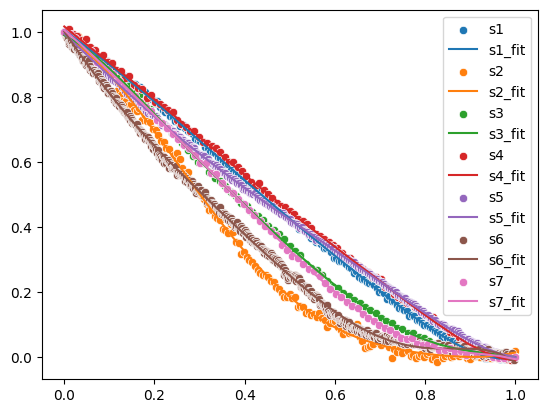

In [9]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=max_degree, plot_fit_str='s1', verbose=True,
                                                        fit=fit
                                                        )
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=max_degree, plot_fit_str='s2', verbose=True,
                                                        fit=fit
                                                        )
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=max_degree, plot_fit_str='s3', verbose=True,
                                                        fit=fit
                                                        )
time_point_4, s_conc_point_4 = generate_time_conc_curve(time_4, s_conc_4, max_degree=max_degree, plot_fit_str='s4', verbose=True,
                                                        fit=fit
                                                        )
time_point_5, s_conc_point_5 = generate_time_conc_curve(time_5, s_conc_5, max_degree=max_degree, plot_fit_str='s5', verbose=True,
                                                        fit=fit
                                                        )
time_point_6, s_conc_point_6 = generate_time_conc_curve(time_6, s_conc_6, max_degree=max_degree, plot_fit_str='s6', verbose=True,
                                                        fit=fit
                                                        )
time_point_7, s_conc_point_7 = generate_time_conc_curve(time_7, s_conc_7, max_degree=max_degree, plot_fit_str='s7', verbose=True,
                                                        fit=fit
                                                        )


In [10]:
# featurize

df_paper_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'M2': {'s': s_conc_point_1},
        'M3': {'s': s_conc_point_2},
        'M4': {'s': s_conc_point_3},
        'M5': {'s': s_conc_point_4},
        'M6': {'s': s_conc_point_5},
        'M7': {'s': s_conc_point_6},
        'M1': {'s': s_conc_point_7},
    },
    sp_mode = sp_mode
)

df_paper_raw_data = conc_points2raw_data(
    conc_points = {
        'M2': {'s': s_conc_point_1},
        'M3': {'s': s_conc_point_2},
        'M4': {'s': s_conc_point_3},
        'M5': {'s': s_conc_point_4},
        'M6': {'s': s_conc_point_5},
        'M7': {'s': s_conc_point_6},
        'M1': {'s': s_conc_point_7},
    },
    sp_mode = sp_mode
)
df_paper_data = pd.merge(df_paper_raw_data, df_paper_tsfresh_data, on='id')
df_paper_data

Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 169.25it/s]


id        s0        s1        s2        s3        s4        s5        s6  \
0  M2   1.00502  0.968922  0.932469  0.895212  0.856938  0.817611  0.777325   
1  M3   0.99034  0.956373  0.913715  0.863485   0.80701  0.745742  0.681194   
2  M4  0.989088  0.961654  0.925032  0.882289  0.835752  0.787128  0.737621   
3  M5  1.016177  0.977115  0.938963  0.900986  0.862735  0.823989  0.784697   
4  M6  0.993381  0.949088  0.904572  0.860268  0.816538  0.773667  0.731867   
5  M7  1.000863  0.932097  0.866553  0.804666  0.746448   0.69161  0.639677   
6  M1  1.005133  0.963376  0.919357  0.873979  0.827816  0.781195   0.73427   

         s7        s8  ... s__catch22__FC_LocalSimple_mean1_tauresrat  \
0  0.736263  0.694654  ...                                   0.818182   
1  0.614878  0.548249  ...                                   0.909091   
2  0.688037  0.638875  ...                                   0.818182   
3  0.744929  0.704835  ...                                   0.909091   
4  0.691278  0.651971  ...                                   1.090909   
5  0.590078  0.542236  ...                                   0.909091   
6  0.687083  0.639622  ...                                   0.818182   

  s__catch22__DN_OutlierInclude_p_001_mdrmd  \
0                                 -0.700000   
1                                 -0.733333   
2                                 -0.700000   
3                                 -0.700000   
4                                 -0.733333   
5                                 -0.733333   
6                                 -0.700000   

  s__catch22__DN_OutlierInclude_n_001_mdrmd  \
0                                  0.700000   
1                                  0.566667   
2                                  0.633333   
3                                  0.733333   
4                                  0.733333   
5                                  0.600000   
6                                  0.633333   

  s__catch22__SP_Summaries_welch_rect_area_5_1  \
0                                     0.868486   
1                                     0.870942   
2                                     0.871427   
3                                     0.859135   
4                                     0.848478   
5                                     0.841419   
6                                     0.868675   

  s__catch22__SB_BinaryStats_diff_longstretch0  \
0                                         28.0   
1                                         26.0   
2                                         28.0   
3                                         28.0   
4                                         28.0   
5                                         25.0   
6                                         28.0   

  s__catch22__SB_MotifThree_quantile_hh  \
0                              1.321604   
1                              1.321604   
2                              1.321604   
3                              1.321604   
4                              1.321604   
5                              1.321604   
6                              1.321604   

  s__catch22__SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        
5                                                0.0        
6                                                0.0        

  s__catch22__SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
5                                                0.0   
6  

In [11]:
Ye_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_paper_data)

In [12]:
df_paper_pred_results = pd.DataFrame({
    'id': df_paper_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_probs_5'],
})
df_paper_pred_results = df_paper_pred_results.round(3)
df_paper_pred_results = df_paper_pred_results.sort_values(by='id').reset_index(drop=True)
df_paper_pred_results.T.to_csv('Ye_paper_pred_results.csv')
df_paper_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0  M1     mm_1           0.723     zero           0.098    first   
1  M2     mm_1           0.551     zero           0.255     mm_2   
2  M3     mm_1           0.733    first           0.075     mm_2   
3  M4     mm_1           0.766     zero           0.062    first   
4  M5     mm_1           0.680     zero           0.137   second   
5  M6    first           0.744     mm_1           0.073     mm_2   
6  M7    first           0.719     mm_2           0.083     mm_1   

   pred_3rd_proba pred_4th  pred_4th_proba pred_5th  pred_5th_proba  
0           0.060     mm_2           0.059   second           0.059  
1           0.065    first           0.065   second           0.064  
2           0.067     zero           0.064   second           0.061  
3           0.058     mm_2           0.057   second           0.057  
4           0.061     mm_2           0.061    first           0.061  
5           0.066   second           0.059     zero           0.058  
6           0.079   second           0.061     zero           0.058

In [ ]:
df_paper_pred_results = pd.DataFrame({
    'id': df_paper_data['id'],
    'pred_1st': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(Ye_norm_cat_proba, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(Ye_norm_cat_proba, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(Ye_norm_cat_proba, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(Ye_norm_cat_proba, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(Ye_norm_cat_proba, x=5)['list_probs_5'],
})
df_paper_pred_results = df_paper_pred_results.round(3)
df_paper_pred_results = df_paper_pred_results.sort_values(by='id').reset_index(drop=True)
df_paper_pred_results

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0  M2     mm_1           0.606     zero           0.201     mm_2   
1  M3     mm_1           0.354    first           0.268     mm_2   
2  M4     mm_1           0.405    first           0.246     mm_2   
3  M5     mm_1           0.608     zero           0.164    first   
4  M6    first           0.744     mm_1           0.073     mm_2   
5  M7    first           0.306     mm_1           0.295     mm_2   

   pred_3rd_proba pred_4th  pred_4th_proba pred_5th  pred_5th_proba  
0           0.064    first           0.064   second           0.064  
1           0.182     zero           0.115   second           0.080  
2           0.159   second           0.100     zero           0.090  
3           0.094     mm_2           0.069   second           0.065  
4           0.066   second           0.059     zero           0.058  
5           0.237   second           0.095     zero           0.068

## Ye_EWG

In [19]:
df_Ye_EWG = pd.read_csv('./experiments/Ye_EWG.csv')
df_Ye_EWG

time        S   catT  time.1       S.1  catT.1  time.2       S.2  catT.2
0     0.0  0.19988  0.002       0  0.200169   0.002     0.0  0.190058   0.002
1     1.0  0.19904  0.002       1  0.198848   0.002     1.0  0.190599   0.002
2     2.0  0.19661  0.002       2  0.200708   0.002     2.0  0.189889   0.002
3     3.0  0.19657  0.002       3  0.197312   0.002     3.0  0.188893   0.002
4     4.0  0.19538  0.002       4  0.195802   0.002     4.0  0.188329   0.002
..    ...      ...    ...     ...       ...     ...     ...       ...     ...
518   NaN      NaN    NaN     518  0.002460   0.002     NaN       NaN     NaN
519   NaN      NaN    NaN     519  0.000843   0.002     NaN       NaN     NaN
520   NaN      NaN    NaN     520  0.000088   0.002     NaN       NaN     NaN
521   NaN      NaN    NaN     521  0.002029   0.002     NaN       NaN     NaN
522   NaN      NaN    NaN     522  0.000115   0.002     NaN       NaN     NaN

[523 rows x 9 columns]

In [20]:
# only S
sp_mode = 's'

time_1 = normalize(df_Ye_EWG['time'].dropna().values)
s_conc_1 = df_Ye_EWG['S'].dropna().values/df_Ye_EWG['S'].dropna().values[0]

time_2 = normalize(df_Ye_EWG['time.1'].dropna().values)
s_conc_2 = df_Ye_EWG['S.1'].dropna().values/df_Ye_EWG['S.1'].dropna().values[0]

time_3 = normalize(df_Ye_EWG['time.2'].dropna().values)
s_conc_3 = df_Ye_EWG['S.2'].dropna().values/df_Ye_EWG['S.2'].dropna().values[0]

# time_4 = normalize(df_Ye_EWG['time.3'].dropna().values)
# s_conc_4 = df_Ye_EWG['S.3'].dropna().values/df_Ye_EWG['S.3'].dropna().values[0]

if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

print('====================')

# if is_quick_rxn(time_4, s_conc_4, obj='s'):
#     print('need to cut time_4')
#     time_4, s_conc_4 = cut_rxn_time(time_4, s_conc_4, obj='s')
# else:
#     print('time_4 is fine')
# if is_completed_rxn(s_conc_4, obj='s'):
#     print('rxn_4 is completed')
# else:
#     print('rxn_4 may be not completed')
    


time_1 is fine
rxn_1 is completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed


best degree: 6
best mse: 7.3363774714280895e-06
best degree: 6
best mse: 3.702588957198537e-05
best degree: 6
best mse: 7.1613230992583836e-06


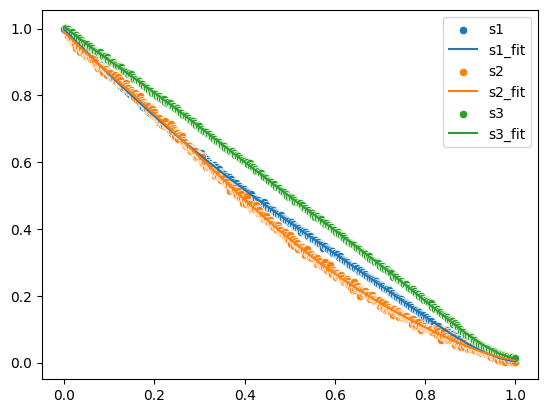

In [21]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=6, plot_fit_str='s1', verbose=True, 
                                                        # fit=False
                                                        )
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=6, plot_fit_str='s2', verbose=True, 
                                                        # fit=False
                                                        )
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=6, plot_fit_str='s3', verbose=True, 
                                                        # fit=False
                                                        )
# time_point_4, s_conc_point_4 = generate_time_conc_curve(time_4, s_conc_4, max_degree=6, plot_fit_str='s4', verbose=True,
#                                                         # fit=False
#                                                         )

Text(0, 0.5, '[M1] (M)')

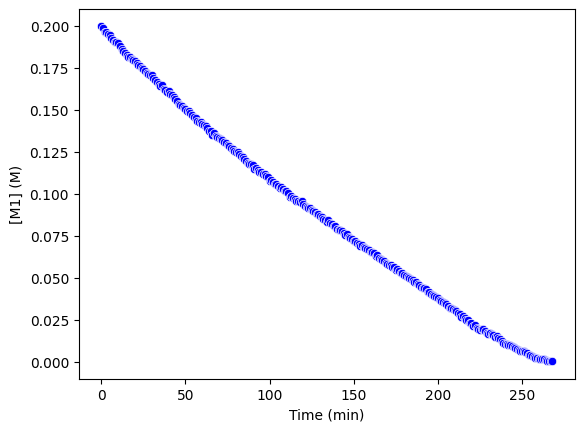

In [22]:
sns.scatterplot(x=df_Ye_EWG['time'].dropna().values, y=df_Ye_EWG['S'].dropna().values, color='blue')
plt.ylim(-0.01, 0.21)
plt.xlabel('Time (min)')
plt.ylabel('[M1] (M)')

In [23]:
# featurize

df_Ye_EWG_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'Ye_EWG_rxn_1': {'s': s_conc_point_1},
        'Ye_EWG_rxn_2': {'s': s_conc_point_2},
        'Ye_EWG_rxn_3': {'s': s_conc_point_3},
        # 'Ye_EWG_rxn_4': {'s': s_conc_point_4},
    },
    sp_mode = sp_mode
)

df_Ye_EWG_raw_data = conc_points2raw_data(
    conc_points = {
        'Ye_EWG_rxn_1': {'s': s_conc_point_1},
        'Ye_EWG_rxn_2': {'s': s_conc_point_2},
        'Ye_EWG_rxn_3': {'s': s_conc_point_3},
        # 'Ye_EWG_rxn_4': {'s': s_conc_point_4},
    },
    sp_mode = sp_mode
)
df_Ye_EWG_data = pd.merge(df_Ye_EWG_tsfresh_data, df_Ye_EWG_raw_data, on='id')
df_Ye_EWG_data

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 75.69it/s]


id  s__variance_larger_than_standard_deviation  \
0  Ye_EWG_rxn_1                                         0.0   
1  Ye_EWG_rxn_2                                         0.0   
2  Ye_EWG_rxn_3                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0      13.258206       8.553013            0.034275       -0.034275   
1      12.590017       8.158016            0.033882       -0.033882   
2      14.927496      10.221058            0.034326       -0.034326   

   s__mean_second_derivative_central  ...       s20       s21       s22  \
0                           0.000664  ...  0.242236  0.209584   0.17688   
1                           0.000637  ...  0.187401  0.160263  0.134628   
2                           0.000394  ...  0.304224  0.267723  0.230493   

        s23       s24       s25       s26       s27       s28       s29  
0  0.144432  0.112743  0.082557  0.054907  0.031159  0.013066  0.002825  
1  0.110393  0.087543   0.06621  0.046724  0.029685  0.016034  0.007131  
2  0.192714  0.154838   0.11768   0.08251  0.051162   0.02615  0.010792  

[3 rows x 836 columns]

In [24]:
# predict
Ye_EWG_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_Ye_EWG_data)
# Ye_EWG_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_Ye_EWG_data)
# Ye_EWG_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_Ye_EWG_data)

#### key data!! Ye_EWG_rxn_1	first	0.735717	mm_1	0.074437	
first 0.736 -> 0.763

In [11]:
# previous with random seed 42
df_Ye_EWG_pred_results = pd.DataFrame({
    'id': df_Ye_EWG_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_EWG_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  Ye_EWG_rxn_1             first                 0.735717              mm_1   
1  Ye_EWG_rxn_2              mm_1                 0.754193              mm_2   
2  Ye_EWG_rxn_3              zero                 0.690644              mm_1   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  
0                 0.074437              mm_2                 0.066356  
1                 0.061608              zero                 0.061603  
2                 0.113577            second                 0.065435

In [23]:
# latest with random seed 29
df_Ye_EWG_pred_results = pd.DataFrame({
    'id': df_Ye_EWG_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_probs_3'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_EWG_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  Ye_EWG_rxn_1             first                 0.763284              mm_1   
1  Ye_EWG_rxn_2              mm_1                 0.776818              mm_2   
2  Ye_EWG_rxn_3              zero                 0.708680              mm_1   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  
0                 0.063227              mm_2                 0.060116  
1                 0.055901            second                 0.055851  
2                 0.117884            second                 0.057870

In [26]:
# latest with random seed 29
df_Ye_EWG_pred_results = pd.DataFrame({
    'id': df_Ye_EWG_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=3)['list_probs_3'],
    'norm_cat_pred_4th': get_top_x_probs(Ye_EWG_norm_cat_proba, x=4)['list_indices_4'],
    'norm_cat_pred_4th_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=4)['list_probs_4'],
    'norm_cat_pred_5th': get_top_x_probs(Ye_EWG_norm_cat_proba, x=5)['list_indices_5'],
    'norm_cat_pred_5th_proba': get_top_x_probs(Ye_EWG_norm_cat_proba, x=5)['list_probs_5'],
    # 'higher_cat_pred_1st': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_indices_1'],
    # 'higher_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=1)['list_probs_1'],
    # 'higher_cat_pred_2nd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_indices_2'],
    # 'higher_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=2)['list_probs_2'],
    # 'higher_cat_pred_3rd': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_indices_3'],
    # 'higher_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_higher_cat_proba, x=3)['list_probs_3'],
    # 'lower_cat_pred_1st': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_indices_1'],
    # 'lower_cat_pred_1st_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=1)['list_probs_1'],
    # 'lower_cat_pred_2nd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_indices_2'],
    # 'lower_cat_pred_2nd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=2)['list_probs_2'],
    # 'lower_cat_pred_3rd': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_indices_3'],
    # 'lower_cat_pred_3rd_proba': get_top_x_probs(Ye_EWG_lower_cat_proba, x=3)['list_probs_3'],
})
df_Ye_EWG_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  Ye_EWG_rxn_1             first                 0.763284              mm_1   
1  Ye_EWG_rxn_2              mm_1                 0.776818              mm_2   
2  Ye_EWG_rxn_3              zero                 0.708680              mm_1   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.063227              mm_2                 0.060116   
1                 0.055901            second                 0.055851   
2                 0.117884            second                 0.057870   

  norm_cat_pred_4th  norm_cat_pred_4th_proba norm_cat_pred_5th  \
0            second                 0.056931              zero   
1             first                 0.055750              zero   
2              mm_2                 0.057857             first   

   norm_cat_pred_5th_proba  
0                 0.056442  
1                 0.055680  
2                 0.057708

In [12]:
Ye_EWG_rxn_1_cat_eq = df_Ye_EWG['catT'].dropna().values[0] / df_Ye_EWG['S'].dropna().values[0]
print(f'catalyst eq. of Ye_EWG rxn_1: {Ye_EWG_rxn_1_cat_eq:.5f}')
Ye_EWG_rxn_2_cat_eq = df_Ye_EWG['catT.1'].dropna().values[0] / df_Ye_EWG['S.1'].dropna().values[0]
print(f'catalyst eq. of Ye_EWG rxn_2: {Ye_EWG_rxn_2_cat_eq:.5f}')
Ye_EWG_rxn_3_cat_eq = df_Ye_EWG['catT.2'].dropna().values[0] / df_Ye_EWG['S.2'].dropna().values[0]
print(f'catalyst eq. of Ye_EWG rxn_3: {Ye_EWG_rxn_3_cat_eq:.5f}')
# Ye_EWG_rxn_4_cat_eq = df_Ye_EWG['catT.3'].dropna().values[0] / df_Ye_EWG['S.3'].dropna().values[0]
# print(f'catalyst eq. of Ye_EWG rxn_4: {Ye_EWG_rxn_4_cat_eq:.5f}')
print('======================')
print(f'Ye_EWG rxn_1 prefers to {judege_cat_eq(Ye_EWG_rxn_1_cat_eq)}')
print(f'Ye_EWG rxn_2 prefers to {judege_cat_eq(Ye_EWG_rxn_2_cat_eq)}')
print(f'Ye_EWG rxn_3 prefers to {judege_cat_eq(Ye_EWG_rxn_3_cat_eq)}')
# print(f'Ye_EWG rxn_4 prefers to {judege_cat_eq(Ye_EWG_rxn_4_cat_eq)}')

catalyst eq. of Ye_EWG rxn_1: 0.01001
catalyst eq. of Ye_EWG rxn_2: 0.00999
catalyst eq. of Ye_EWG rxn_3: 0.01052
Ye_EWG rxn_1 prefers to norm_cat
Ye_EWG rxn_2 prefers to norm_cat
Ye_EWG rxn_3 prefers to norm_cat


In [12]:
# df_Ye_EWG_pred_results[['id'] + [c for c in df_Ye_EWG_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba
0  Ye_EWG_rxn_1             first                 0.693772
1  Ye_EWG_rxn_2              mm_1                 0.905861
2  Ye_EWG_rxn_3              zero                 0.780611
3  Ye_EWG_rxn_4              mm_1                 0.904803

# Lv's Cases

In [5]:
df_lv = pd.read_csv('./experiments/Lv.csv')
df_lv

time          S   catT      time.1         S.1  catT.1     time.2  \
0      0.00000  100.00000  0.001     0.00000  100.045800   0.001    0.00000   
1     29.96821   94.10106  0.001    29.99867   99.751630   0.001   29.97757   
2     59.93642   82.28400  0.001    89.99601   99.352180   0.001   59.95513   
3     89.90463   69.75430  0.001   119.99470   98.692650   0.001   89.93270   
4    119.87280   55.06171  0.001   149.99340   97.833450   0.001  119.91030   
..         ...        ...    ...         ...         ...     ...        ...   
253        NaN        NaN    NaN  7619.66200    0.466272   0.001        NaN   
254        NaN        NaN    NaN  7649.66100    0.423954   0.001        NaN   
255        NaN        NaN    NaN  7679.65900    0.279444   0.001        NaN   
256        NaN        NaN    NaN  7709.65800    0.258109   0.001        NaN   
257        NaN        NaN    NaN  7739.65700    0.181833   0.001        NaN   

           S.2  catT.2     time.3  ...  catT.3     time.4        S.4  catT.4  \
0     99.01621   0.001    0.00000  ...   0.001    0.00000  100.00000   0.001   
1    100.00000   0.001   29.97757  ...   0.001   29.98527   97.64475   0.001   
2     97.72857   0.001   59.95513  ...   0.001   59.97055   93.90446   0.001   
3     95.79781   0.001   89.93270  ...   0.001   89.95582   89.11848   0.001   
4     93.93812   0.001  119.91030  ...   0.001  119.94110   84.24083   0.001   
..         ...     ...        ...  ...     ...        ...        ...     ...   
253        NaN     NaN        NaN  ...     NaN        NaN        NaN     NaN   
254        NaN     NaN        NaN  ...     NaN        NaN        NaN     NaN   
255        NaN     NaN        NaN  ...     NaN        NaN        NaN     NaN   
256        NaN     NaN        NaN  ...     NaN        NaN        NaN     NaN   
257        NaN     NaN        NaN  ...     NaN        NaN        NaN     NaN   

        time.5        S.5  catT.5     time.6       S.6  catT.6  
0      0.00000  100.00000   0.001    0.00000  99.56292   0.001  
1     29.98503   98.99321   0.001   29.98503  98.98400   0.001  
2     59.97006   97.86217   0.001   59.97006  98.17687   0.001  
3     89.95509   97.36293   0.001   89.95509  97.30178   0.001  
4    119.94010   96.49072   0.001  119.94010  96.45875   0.001  
..         ...        ...     ...        ...       ...     ...  
253        NaN        NaN     NaN        NaN       NaN     NaN  
254        NaN        NaN     NaN        NaN       NaN     NaN  
255        NaN        NaN     NaN        NaN       NaN     NaN  
256        NaN        NaN     NaN        NaN       NaN     NaN  
257        NaN        NaN     NaN        NaN       NaN     NaN  

[258 rows x 21 columns]

In [6]:
# only S
sp_mode = 's'

time_1 = normalize(df_lv['time'].dropna().values)
s_conc_1 = df_lv['S'].dropna().values/df_lv['S'].dropna().values[0]

time_2 = normalize(df_lv['time.1'].dropna().values)
s_conc_2 = df_lv['S.1'].dropna().values/df_lv['S.1'].dropna().values[0]

time_3 = normalize(df_lv['time.2'].dropna().values)
s_conc_3 = df_lv['S.2'].dropna().values/df_lv['S.2'].dropna().values[0]

time_4 = normalize(df_lv['time.3'].dropna().values)
s_conc_4 = df_lv['S.3'].dropna().values/df_lv['S.3'].dropna().values[0]

time_5 = normalize(df_lv['time.4'].dropna().values)
s_conc_5 = df_lv['S.4'].dropna().values/df_lv['S.4'].dropna().values[0]

time_6 = normalize(df_lv['time.5'].dropna().values)
s_conc_6 = df_lv['S.5'].dropna().values/df_lv['S.5'].dropna().values[0]

time_7 = normalize(df_lv['time.6'].dropna().values)
s_conc_7 = df_lv['S.6'].dropna().values/df_lv['S.6'].dropna().values[0]

In [7]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

print('====================')

if is_quick_rxn(time_4, s_conc_4, obj='s'):
    print('need to cut time_4')
    time_4, s_conc_4 = cut_rxn_time(time_4, s_conc_4, obj='s')
else:
    print('time_4 is fine')
if is_completed_rxn(s_conc_4, obj='s'):
    print('rxn_4 is completed')
else:
    print('rxn_4 may be not completed')

print('====================')

if is_quick_rxn(time_5, s_conc_5, obj='s'):
    print('need to cut time_5')
    time_5, s_conc_5 = cut_rxn_time(time_5, s_conc_5, obj='s')
else:
    print('time_5 is fine')
if is_completed_rxn(s_conc_5, obj='s'):
    print('rxn_5 is completed')
else:
    print('rxn_5 may be not completed')

print('====================')

if is_quick_rxn(time_6, s_conc_6, obj='s'):
    print('need to cut time_6')
    time_6, s_conc_6 = cut_rxn_time(time_6, s_conc_6, obj='s')
else:
    print('time_6 is fine')
if is_completed_rxn(s_conc_6, obj='s'):
    print('rxn_6 is completed')
else:
    print('rxn_6 may be not completed')

print('====================')

if is_quick_rxn(time_7, s_conc_7, obj='s'):
    print('need to cut time_7')
    time_7, s_conc_7 = cut_rxn_time(time_7, s_conc_7, obj='s')
else:
    print('time_7 is fine')
if is_completed_rxn(s_conc_7, obj='s'):
    print('rxn_7 is completed')
else:
    print('rxn_7 may be not completed')

time_1 is fine
rxn_1 is completed
need to cut time_2
rxn_2 is completed
time_3 is fine
rxn_3 is completed
time_4 is fine
rxn_4 is completed
time_5 is fine
rxn_5 is completed
time_6 is fine
rxn_6 is completed
time_7 is fine
rxn_7 is completed


In [8]:
max_degree = 6
fit = True

best degree: 6
best mse: 5.308711826128467e-06
best degree: 6
best mse: 2.7678145096795227e-05
best degree: 6
best mse: 0.00012478293278461204
best degree: 6
best mse: 8.378800476508635e-05
best degree: 6
best mse: 3.253359949197305e-06
best degree: 6
best mse: 0.00019355112064419603
best degree: 6
best mse: 0.00018719396207700955


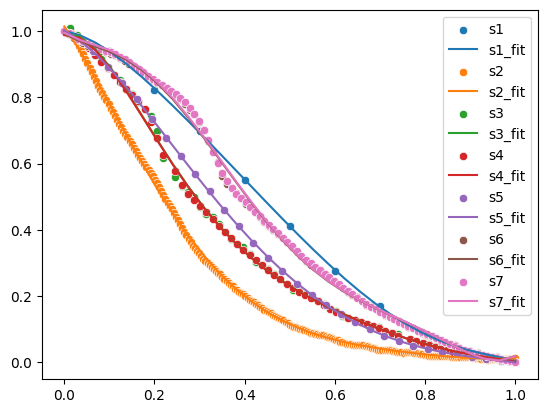

In [9]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=max_degree, plot_fit_str='s1', verbose=True, fit=fit)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=max_degree, plot_fit_str='s2', verbose=True, fit=fit)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=max_degree, plot_fit_str='s3', verbose=True, fit=fit)
time_point_4, s_conc_point_4 = generate_time_conc_curve(time_4, s_conc_4, max_degree=max_degree, plot_fit_str='s4', verbose=True, fit=fit)
time_point_5, s_conc_point_5 = generate_time_conc_curve(time_5, s_conc_5, max_degree=max_degree, plot_fit_str='s5', verbose=True, fit=fit)
time_point_6, s_conc_point_6 = generate_time_conc_curve(time_6, s_conc_6, max_degree=max_degree, plot_fit_str='s6', verbose=True, fit=fit)
time_point_7, s_conc_point_7 = generate_time_conc_curve(time_7, s_conc_7, max_degree=max_degree, plot_fit_str='s7', verbose=True, fit=fit)

In [10]:
# featurize

df_lv_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'Lv_rxn_1': {'s': s_conc_point_1},
        'Lv_rxn_2': {'s': s_conc_point_2},
        'Lv_rxn_3': {'s': s_conc_point_3},
        'Lv_rxn_4': {'s': s_conc_point_4},
        'Lv_rxn_5': {'s': s_conc_point_5},
        'Lv_rxn_6': {'s': s_conc_point_6},
        'Lv_rxn_7': {'s': s_conc_point_7},
    },
    sp_mode = sp_mode
)

df_lv_raw_data = conc_points2raw_data(
    conc_points = {
        'Lv_rxn_1': {'s': s_conc_point_1},
        'Lv_rxn_2': {'s': s_conc_point_2},
        'Lv_rxn_3': {'s': s_conc_point_3},
        'Lv_rxn_4': {'s': s_conc_point_4},
        'Lv_rxn_5': {'s': s_conc_point_5},
        'Lv_rxn_6': {'s': s_conc_point_6},
        'Lv_rxn_7': {'s': s_conc_point_7},
    },
    sp_mode = sp_mode
)

df_lv_data = pd.merge(df_lv_tsfresh_data, df_lv_raw_data, on='id')
df_lv_data

Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 61.87it/s]


id  s__variance_larger_than_standard_deviation  s__has_duplicate_max  \
0  Lv_rxn_1                                         0.0                   0.0   
1  Lv_rxn_2                                         0.0                   0.0   
2  Lv_rxn_3                                         0.0                   0.0   
3  Lv_rxn_4                                         0.0                   0.0   
4  Lv_rxn_5                                         0.0                   0.0   
5  Lv_rxn_6                                         0.0                   0.0   
6  Lv_rxn_7                                         0.0                   0.0   

   s__has_duplicate_min  s__has_duplicate  s__sum_values  s__abs_energy  \
0                   0.0               0.0      13.538787       9.585581   
1                   0.0               0.0       8.111769       5.040679   
2                   0.0               0.0      10.554295       6.880166   
3                   0.0               0.0      10.522648       6.836058   
4                   0.0               0.0      10.979980       7.356650   
5                   0.0               0.0      13.097120       9.286647   
6                   0.0               0.0      13.153847       9.366472   

   s__mean_abs_change  s__mean_change  s__mean_second_derivative_central  ...  \
0            0.034300       -0.034300                           0.000051  ...   
1            0.034610       -0.034545                           0.001314  ...   
2            0.034157       -0.034157                           0.000017  ...   
3            0.033973       -0.033973                           0.000002  ...   
4            0.034541       -0.034541                           0.000433  ...   
5            0.034476       -0.033519                           0.000644  ...   
6            0.034586       -0.033627                           0.000633  ...   

        s20       s21       s22       s23       s24       s25       s26  \
0  0.178027  0.144811  0.115379  0.089945  0.068557  0.051055  0.037004   
1  0.044008  0.037037  0.030922   0.02551  0.020768  0.016765  0.013655   
2  0.106316  0.088944  0.072942  0.058447  0.045613  0.034535  0.025153   
3  0.106035  0.088672  0.072673  0.058183  0.045369  0.034339  0.025042   
4  0.092333  0.073791  0.058196  0.045223  0.034513  0.025674  0.018281   
5  0.164043  0.142475  0.121094   0.09888  0.075465   0.05147  0.028887   
6  0.164758  0.143052  0.121545   0.09922  0.075714  0.051652   0.02903   

        s27       s28       s29  
0  0.025633  0.015762  0.005725  
1  0.011651     0.011  0.011939  
2  0.017133   0.00974  0.001689  
3  0.017162  0.009974  0.002206  
4   0.01188  0.005983  0.000069  
5  0.011498  0.005342  0.019217  
6  0.011631  0.005492  0.019405  

[7 rows x 836 columns]

In [11]:
# predict
df_lv_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_lv_data)

In [12]:
# 6 class
df_lv_pred_results = pd.DataFrame({
    'id': df_lv_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(df_lv_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(df_lv_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(df_lv_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(df_lv_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(df_lv_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(df_lv_norm_cat_proba, x=3)['list_probs_3'],
})
df_lv_pred_results = df_lv_pred_results.round(3)
df_lv_pred_results = df_lv_pred_results.sort_values(by='id', key=lambda x: x.str.split('_').str[-1].astype(int)).reset_index(drop=True)
df_lv_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  Lv_rxn_1              zero                    0.586              mm_1   
1  Lv_rxn_2              mm_1                    0.693             first   
2  Lv_rxn_3              mm_1                    0.663             first   
3  Lv_rxn_4              mm_1                    0.662             first   
4  Lv_rxn_5              mm_1                    0.794             first   
5  Lv_rxn_6              zero                    0.592              mm_1   
6  Lv_rxn_7              zero                    0.590              mm_1   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  
0                    0.290              mm_2                    0.041  
1                    0.124              mm_2                    0.071  
2                    0.151              mm_2                    0.073  
3                    0.158              mm_2                    0.071  
4                    0.067              zero                    0.055  
5                    0.281             first                    0.043  
6                    0.284             first                    0.043

# Reference Cases

## Case 1

In [5]:
df_case_1 = pd.read_csv('./experiments/Kinetic_data_Case_study_1.txt', sep='\t')
df_case_1

time         P  catT     time.1       P.1  catT.1     time.2  \
0       0.0000   0.00000   0.1     0.0000   0.00000     0.2     0.0000   
1      67.2729   1.34436   0.1    60.2729   1.90818     0.2    72.2729   
2     127.2729   4.48873   0.1   120.2729   6.86651     0.2   132.2729   
3     187.2729   8.16379   0.1   180.2729  12.49123     0.2   192.2729   
4     247.2729  11.75105   0.1   240.2729  17.94577     0.2   252.2729   
..         ...       ...   ...        ...       ...     ...        ...   
117  7031.2729  79.04878   0.1  7024.2729  91.56331     0.2  7035.2729   
118  7091.2729  79.09252   0.1  7084.2729  91.63676     0.2  7095.2729   
119  7151.2729  79.13937   0.1  7144.2729  91.68279     0.2  7155.2729   
120  7211.2729  79.19693   0.1  7204.2729  91.63420     0.2  7215.2729   
121  7271.2729  79.12139   0.1  7264.2729  91.73671     0.2  7275.2729   

          P.2  catT.2  
0     0.00000     0.3  
1     5.02919     0.3  
2    12.37320     0.3  
3    20.10444     0.3  
4    27.08155     0.3  
..        ...     ...  
117  96.10090     0.3  
118  96.35575     0.3  
119  96.34210     0.3  
120  96.49118     0.3  
121  96.36608     0.3  

[122 rows x 9 columns]

In [6]:
# only P
sp_mode = 'p'
# value of P corresponds to conversion%
time_1 = normalize(df_case_1['time'].dropna().values)
p_conc_1 = df_case_1['P'].dropna().values/100
time_2 = normalize(df_case_1['time.1'].dropna().values)
p_conc_2 = df_case_1['P.1'].dropna().values/100
time_3 = normalize(df_case_1['time.2'].dropna().values)
p_conc_3 = df_case_1['P.2'].dropna().values/100

In [7]:
if is_quick_rxn(time_1, p_conc_1, obj='p'):
    print('need to cut time_1')
    time_1, p_conc_1 = cut_rxn_time(time_1, p_conc_1, obj='p')
else:
    print('time_1 is fine')
if is_completed_rxn(p_conc_1, obj='p'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, p_conc_2, obj='p'):
    print('need to cut time_2')
    time_2, p_conc_2 = cut_rxn_time(time_2, p_conc_2, obj='p')
else:
    print('time_2 is fine')
if is_completed_rxn(p_conc_2, obj='p'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, p_conc_3, obj='p'):
    print('need to cut time_3')
    time_3, p_conc_3 = cut_rxn_time(time_3, p_conc_3, obj='p')
else:
    print('time_3 is fine')
if is_completed_rxn(p_conc_3, obj='p'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_1 is completed
time_2 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_2 is completed
time_3 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_3 is completed


best degree: 6
best mse: 1.3538365675886232e-05
best degree: 6
best mse: 2.1862082045888297e-05
best degree: 6
best mse: 3.800907025078313e-05


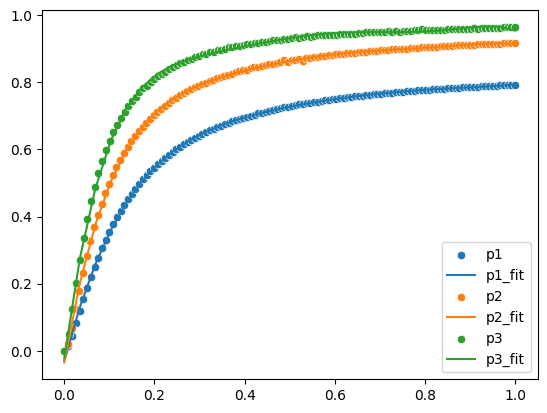

In [8]:
time_point_1, p_conc_point_1 = generate_time_conc_curve(time_1, p_conc_1, max_degree=6, plot_fit_str='p1', verbose=True)
time_point_2, p_conc_point_2 = generate_time_conc_curve(time_2, p_conc_2, max_degree=6, plot_fit_str='p2', verbose=True)
time_point_3, p_conc_point_3 = generate_time_conc_curve(time_3, p_conc_3, max_degree=6, plot_fit_str='p3', verbose=True)

In [9]:
# featurize

df_case_1_tsfresh_data = get_tsfresh_features(
    {
        'case_1_rxn_1': {'p': p_conc_point_1},
        'case_1_rxn_2': {'p': p_conc_point_2},
        'case_1_rxn_3': {'p': p_conc_point_3}
    },
    sp_mode=sp_mode
)

df_case_1_raw_data = conc_points2raw_data(
    {
        'case_1_rxn_1': {'p': p_conc_point_1},
        'case_1_rxn_2': {'p': p_conc_point_2},
        'case_1_rxn_3': {'p': p_conc_point_3}
    },
    sp_mode=sp_mode
)
df_case_1_data = pd.merge(df_case_1_tsfresh_data, df_case_1_raw_data, on='id')
df_case_1_data

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 97.67it/s]


id  p__variance_larger_than_standard_deviation  \
0  case_1_rxn_1                                         0.0   
1  case_1_rxn_2                                         0.0   
2  case_1_rxn_3                                         0.0   

   p__has_duplicate_max  p__has_duplicate_min  p__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   p__sum_values  p__abs_energy  p__mean_abs_change  p__mean_change  \
0      19.118385      13.458697            0.028404        0.028404   
1      23.012379      19.166721            0.032890        0.032733   
2      25.125703      22.513184            0.034516        0.033686   

   p__mean_second_derivative_central  ...       p20       p21       p22  \
0                          -0.002801  ...  0.765017  0.769595  0.773544   
1                          -0.004246  ...  0.894267  0.897115  0.899724   
2                          -0.005500  ...  0.949448  0.949413  0.949782   

        p23       p24       p25       p26       p27       p28       p29  
0  0.776925  0.779838  0.782416  0.784831  0.787287  0.790013  0.793251  
1  0.902401  0.905376  0.908711  0.912193  0.915194  0.916525  0.914261  
2  0.951195  0.954042  0.958242  0.962973  0.966373  0.965186   0.95438  

[3 rows x 836 columns]

In [10]:
# predict
case_1_norm_cat_proba = ag_model_norm_cat_p.predict_proba(df_case_1_data)
case_1_higher_cat_proba = ag_model_higher_cat_p.predict_proba(df_case_1_data)
case_1_lower_cat_proba = ag_model_lower_cat_p.predict_proba(df_case_1_data)

In [11]:
df_case_1_pred_results = pd.DataFrame({
    'id': df_case_1_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_1_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_1_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_1_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_1_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_1_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_1_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_1_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_1_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_1_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_1_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_1_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_1_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_1_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_1_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_1_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_1_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_1_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_1_lower_cat_proba, x=3)['list_probs_3']
})
df_case_1_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  case_1_rxn_1             first                 0.481553          mm_1_out   
1  case_1_rxn_2             first                 0.566214          mm_1_out   
2  case_1_rxn_3             first                 0.839628              mm_2   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.360220              mm_2                 0.046718   
1                 0.249168              mm_2                 0.058439   
2                 0.044147            second                 0.040878   

  higher_cat_pred_1st  higher_cat_pred_1st_proba higher_cat_pred_2nd  \
0            mm_1_out                   0.484822                zero   
1            mm_1_out                   0.815786                zero   
2            mm_1_out                   0.801478               first   

   higher_cat_pred_2nd_proba higher_cat_pred_3rd  higher_cat_pred_3rd_proba  \
0                   0.206784                mm_2                   0.190587   
1                   0.046677               first                   0.043537   
2                   0.063472                zero                   0.039576   

  lower_cat_pred_1st  lower_cat_pred_1st_proba lower_cat_pred_2nd  \
0              first                  0.467743           mm_1_out   
1              first                  0.458486           mm_1_out   
2              first                  0.734218               mm_2   

   lower_cat_pred_2nd_proba lower_cat_pred_3rd  lower_cat_pred_3rd_proba  
0                  0.341508             second                  0.054134  
1                  0.300686               mm_2                  0.107319  
2                  0.116027             second                  0.055400

In [12]:
case_1_rxn_1_cat_eq = 0.001
print(f'catalyst eq. of case_1 rxn_1: {case_1_rxn_1_cat_eq}')
case_1_rxn_2_cat_eq = 0.002
print(f'catalyst eq. of case_1 rxn_2: {case_1_rxn_2_cat_eq}')
case_1_rxn_3_cat_eq = 0.003
print(f'catalyst eq. of case_1 rxn_3: {case_1_rxn_3_cat_eq}')
print('======================')
print(f'case_1 rxn_1 prefers to {judege_cat_eq(case_1_rxn_1_cat_eq)}')
print(f'case_1 rxn_2 prefers to {judege_cat_eq(case_1_rxn_2_cat_eq)}')
print(f'case_1 rxn_3 prefers to {judege_cat_eq(case_1_rxn_3_cat_eq)}')

catalyst eq. of case_1 rxn_1: 0.001
catalyst eq. of case_1 rxn_2: 0.002
catalyst eq. of case_1 rxn_3: 0.003
case_1 rxn_1 prefers to lower_cat
case_1 rxn_2 prefers to lower_cat
case_1 rxn_3 prefers to lower_cat


In [13]:
df_case_1_pred_results[['id'] + [c for c in df_case_1_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_1_rxn_1             first                 0.481553   
1  case_1_rxn_2             first                 0.566214   
2  case_1_rxn_3             first                 0.839628   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0            mm_1_out                   0.484822              first   
1            mm_1_out                   0.815786              first   
2            mm_1_out                   0.801478              first   

   lower_cat_pred_1st_proba  
0                  0.467743  
1                  0.458486  
2                  0.734218

## Case 2

In [5]:
df_case_2 = pd.read_csv('./experiments/Kinetic_data_Case_study_2.txt', sep='\t')
df_case_2

time        S        P    catT  time.1      S.1      P.1  catT.1  time.2  \
0      0  0.86000  0.00000  0.0215       0  0.86000  0.00000   0.043       0   
1      6  0.84507  0.01493  0.0215       5  0.83663  0.02337   0.043       6   
2     16  0.82785  0.03215  0.0215      15  0.78827  0.07173   0.043      16   
3     28  0.80877  0.05123  0.0215      26  0.75522  0.10478   0.043      27   
4     39  0.78541  0.07459  0.0215      36  0.71814  0.14186   0.043      37   
5     48  0.77574  0.08426  0.0215      46  0.68349  0.17651   0.043      48   
6     57  0.76094  0.09906  0.0215      56  0.64480  0.21520   0.043      57   
7     67  0.74444  0.11556  0.0215      65  0.61981  0.24019   0.043      68   
8     78  0.71999  0.14001  0.0215      89  0.54244  0.31756   0.043      77   
9     99  0.69165  0.16835  0.0215      96  0.53599  0.32401   0.043      88   
10   108  0.67700  0.18300  0.0215     106  0.51100  0.34900   0.043      98   

        S.2      P.2  catT.2  time.3      S.3      P.3  catT.3  
0   0.86000  0.00000   0.086       0  0.43000  0.00000   0.043  
1   0.79197  0.06803   0.086       6  0.39695  0.03305   0.043  
2   0.70364  0.15636   0.086      16  0.36633  0.06367   0.043  
3   0.63029  0.22971   0.086      27  0.32741  0.10259   0.043  
4   0.56420  0.29580   0.086      39  0.29701  0.13299   0.043  
5   0.49569  0.36431   0.086      52  0.25772  0.17228   0.043  
6   0.43363  0.42637   0.086      64  0.23155  0.19845   0.043  
7   0.39300  0.46700   0.086      75  0.19850  0.23150   0.043  
8   0.32159  0.53841   0.086      85  0.16787  0.26213   0.043  
9   0.27749  0.58251   0.086      95  0.14530  0.28470   0.043  
10  0.23953  0.62047   0.086     106  0.10110  0.32890   0.043

In [6]:
# S and P
sp_mode = 'sp'

time_1 = normalize(df_case_2['time'].dropna().values)
s_conc_1 = df_case_2['S'].dropna().values/df_case_2['S'].dropna().values[0]
p_conc_1 = df_case_2['P'].dropna().values/df_case_2['S'].dropna().values[0]

time_2 = normalize(df_case_2['time.1'].dropna().values)
s_conc_2 = df_case_2['S.1'].dropna().values/df_case_2['S.1'].dropna().values[0]
p_conc_2 = df_case_2['P.1'].dropna().values/df_case_2['S.1'].dropna().values[0]

time_3 = normalize(df_case_2['time.2'].dropna().values)
s_conc_3 = df_case_2['S.2'].dropna().values/df_case_2['S.2'].dropna().values[0]
p_conc_3 = df_case_2['P.2'].dropna().values/df_case_2['S.2'].dropna().values[0]

In [7]:
if is_quick_rxn(time_1, p_conc_1, obj='p') or is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, p_conc_1 = cut_rxn_time(time_1, p_conc_1, obj='p')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
    if p_conc_1.shape[0] != s_conc_1.shape[0]:
        raise ValueError('cutting rxn time error with rxn_1')
else:
    print('time_1 is fine')
if is_completed_rxn(p_conc_1, obj='p') or is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, p_conc_2, obj='p') or is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, p_conc_2 = cut_rxn_time(time_2, p_conc_2, obj='p')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
    if p_conc_2.shape[0] != s_conc_2.shape[0]:
        raise ValueError('cutting rxn time error with rxn_2')
else:
    print('time_2 is fine')
if is_completed_rxn(p_conc_2, obj='p') or is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, p_conc_3, obj='p') or is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, p_conc_3 = cut_rxn_time(time_3, p_conc_3, obj='p')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
    if p_conc_3.shape[0] != s_conc_3.shape[0]:
        raise ValueError('cutting rxn time error with rxn_3')
else:
    print('time_3 is fine')
if is_completed_rxn(p_conc_3, obj='p') or is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_1 may be not completed
time_2 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_2 may be not completed
time_3 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_3 is completed


best degree: 3
best mse: 6.898514853081726e-06
best degree: 4
best mse: 5.44261874800798e-06
best degree: 3
best mse: 1.984586486823189e-05
best degree: 4
best mse: 1.4094127625777863e-05
best degree: 3
best mse: 7.64579211445558e-05
best degree: 4
best mse: 4.640556018294341e-05


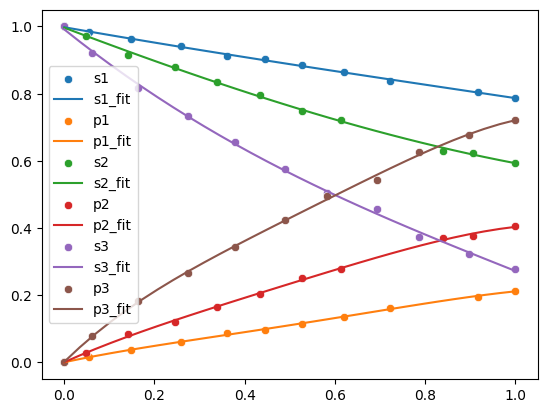

In [8]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=3, plot_fit_str='s1', verbose=True)
time_point_1_, p_conc_point_1 = generate_time_conc_curve(time_1, p_conc_1, plot_fit_str='p1', verbose=True)
assert np.all(time_point_1 == time_point_1_)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=3, plot_fit_str='s2', verbose=True)
time_point_2_, p_conc_point_2 = generate_time_conc_curve(time_2, p_conc_2, plot_fit_str='p2', verbose=True)
assert np.all(time_point_2 == time_point_2_)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=3, plot_fit_str='s3', verbose=True)
time_point_3_, p_conc_point_3 = generate_time_conc_curve(time_3, p_conc_3, plot_fit_str='p3', verbose=True)
assert np.all(time_point_3 == time_point_3_)

In [9]:
# featurize

df_case_2_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_2_rxn_1': {'s': s_conc_point_1, 'p': p_conc_point_1},
        'case_2_rxn_2': {'s': s_conc_point_2, 'p': p_conc_point_2},
        'case_2_rxn_3': {'s': s_conc_point_3, 'p': p_conc_point_3}
    },
    sp_mode = sp_mode
)

df_case_2_raw_data = conc_points2raw_data(
    conc_points = {
        'case_2_rxn_1': {'s': s_conc_point_1, 'p': p_conc_point_1},
        'case_2_rxn_2': {'s': s_conc_point_2, 'p': p_conc_point_2},
        'case_2_rxn_3': {'s': s_conc_point_3, 'p': p_conc_point_3}
    },
    sp_mode = sp_mode
)
df_case_2_data = pd.merge(df_case_2_tsfresh_data, df_case_2_raw_data, on='id')
df_case_2_data

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 206.25it/s]


id  p__variance_larger_than_standard_deviation  \
0  case_2_rxn_1                                         0.0   
1  case_2_rxn_2                                         0.0   
2  case_2_rxn_3                                         0.0   

   p__has_duplicate_max  p__has_duplicate_min  p__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   p__sum_values  p__abs_energy  p__mean_abs_change  p__mean_change  \
0       3.328715       0.487759            0.007275        0.007275   
1       6.777833       1.977085            0.013886        0.013886   
2      12.384192       6.446300            0.024793        0.024793   

   p__mean_second_derivative_central  ...       p20       p21       p22  \
0                          -0.000078  ...  0.151641  0.159138  0.166573   
1                          -0.000252  ...  0.310968  0.324141  0.336882   
2                          -0.000562  ...  0.556138  0.578455  0.600294   

        p23       p24       p25       p26       p27       p28       p29  
0  0.173896  0.181049  0.187966  0.194574  0.200793  0.206536  0.211707  
1  0.349088  0.360641   0.37141  0.381252  0.390009  0.397512  0.403576  
2  0.621477    0.6418  0.661023  0.678877  0.695062  0.709245  0.721064  

[3 rows x 1671 columns]

In [10]:
# predict
# case_2_norm_cat_pred = ag_model_norm_cat_sp.predict(df_case_2_data)
case_2_norm_cat_proba = ag_model_norm_cat_sp.predict_proba(df_case_2_data)
# case_2_higher_cat_pred = ag_model_higher_cat_sp.predict(df_case_2_data)
case_2_higher_cat_proba = ag_model_higher_cat_sp.predict_proba(df_case_2_data)
# case_2_lower_cat_pred = ag_model_lower_cat_sp.predict(df_case_2_data)
case_2_lower_cat_proba = ag_model_lower_cat_sp.predict_proba(df_case_2_data)

In [11]:
df_case_2_pred_results = pd.DataFrame({
    'id': df_case_2_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_2_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_2_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_2_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_2_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_2_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_2_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_2_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_2_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_2_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_2_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_2_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_2_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_2_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_2_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_2_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_2_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_2_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_2_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_2_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  case_2_rxn_1              mm_2                 0.350395             first   
1  case_2_rxn_2             first                 0.345318              mm_2   
2  case_2_rxn_3              mm_1                 0.573049             first   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.338171            second                 0.150238   
1                 0.284553              mm_1                 0.171859   
2                 0.151408              mm_2                 0.074700   

  higher_cat_pred_1st  higher_cat_pred_1st_proba higher_cat_pred_2nd  \
0                mm_2                   0.850052              second   
1                mm_2                   0.942984              second   
2                mm_2                   0.974075              second   

   higher_cat_pred_2nd_proba higher_cat_pred_3rd  higher_cat_pred_3rd_proba  \
0                   0.134085               first                   0.015539   
1                   0.053447               first                   0.003307   
2                   0.022212               first                   0.003138   

  lower_cat_pred_1st  lower_cat_pred_1st_proba lower_cat_pred_2nd  \
0               mm_2                  0.434922              first   
1              first                  0.423385               mm_2   
2               mm_1                  0.860525              first   

   lower_cat_pred_2nd_proba lower_cat_pred_3rd  lower_cat_pred_3rd_proba  
0                  0.347069             second                  0.126523  
1                  0.349056               mm_1                  0.154848  
2                  0.071055           mm_1_out                  0.022034

In [12]:
case_1_rxn_1_cat_eq = df_case_2['catT'].dropna().values[0] / df_case_2['S'].dropna().values[0]
print(f'catalyst eq. of case_2 rxn_1: {case_1_rxn_1_cat_eq:.5f}')
case_1_rxn_2_cat_eq = df_case_2['catT.1'].dropna().values[0] / df_case_2['S.1'].dropna().values[0]
print(f'catalyst eq. of case_2 rxn_2: {case_1_rxn_2_cat_eq:.5f}')
case_1_rxn_3_cat_eq = df_case_2['catT.2'].dropna().values[0] / df_case_2['S.2'].dropna().values[0]
print(f'catalyst eq. of case_2 rxn_3: {case_1_rxn_3_cat_eq:.5f}')
print('======================')
print(f'case_2 rxn_1 prefers to {judege_cat_eq(case_1_rxn_1_cat_eq)}')
print(f'case_2 rxn_2 prefers to {judege_cat_eq(case_1_rxn_2_cat_eq)}')
print(f'case_2 rxn_3 prefers to {judege_cat_eq(case_1_rxn_3_cat_eq)}')

catalyst eq. of case_2 rxn_1: 0.02500
catalyst eq. of case_2 rxn_2: 0.05000
catalyst eq. of case_2 rxn_3: 0.10000
case_2 rxn_1 prefers to norm_cat
case_2 rxn_2 prefers to higher_cat
case_2 rxn_3 prefers to higher_cat


In [13]:
df_case_2_pred_results[['id'] + [c for c in df_case_2_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_2_rxn_1              mm_2                 0.350395   
1  case_2_rxn_2             first                 0.345318   
2  case_2_rxn_3              mm_1                 0.573049   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.850052               mm_2   
1                mm_2                   0.942984              first   
2                mm_2                   0.974075               mm_1   

   lower_cat_pred_1st_proba  
0                  0.434922  
1                  0.423385  
2                  0.860525

## Case 3

In [14]:
df_case_3 = pd.read_csv('./experiments/Kinetic_data_Case_study_3.txt', sep='\t')
df_case_3

time         S      catT   time.1       S.1    catT.1   time.2  \
0       0.0  0.099620  0.000251      0.0  0.099620  0.000499      0.0   
1     264.5  0.096198  0.000251    264.5  0.094743  0.000499    264.5   
2    1058.0  0.091754  0.000251    529.0  0.091106  0.000499    529.0   
3    1851.5  0.088040  0.000251   1058.0  0.085147  0.000499    793.5   
4    2645.0  0.084634  0.000251   1587.0  0.079805  0.000499   1058.0   
5    3703.0  0.080548  0.000251   1851.5  0.076934  0.000499   1322.5   
6    4761.0  0.076937  0.000251   2645.0  0.070466  0.000499   1587.0   
7    5819.0  0.073628  0.000251   3174.0  0.066418  0.000499   1851.5   
8    7141.5  0.069917  0.000251   3967.5  0.061209  0.000499   2116.0   
9    8728.5  0.065953  0.000251   4761.0  0.056249  0.000499   2380.5   
10  10580.0  0.061803  0.000251   5554.5  0.052339  0.000499   2645.0   
11  12431.5  0.058131  0.000251   6612.5  0.047291  0.000499   3174.0   
12  14283.0  0.054808  0.000251   7670.5  0.042789  0.000499   3438.5   
13  16663.5  0.050931  0.000251   8993.0  0.038332  0.000499   4232.0   
14  19308.5  0.047139  0.000251  10580.0  0.033174  0.000499   4761.0   
15  22482.5  0.043256  0.000251  12167.0  0.028879  0.000499   5554.5   
16  25921.0  0.039464  0.000251  14547.5  0.024052  0.000499   6612.5   
17  29888.5  0.035747  0.000251  17192.5  0.019083  0.000499   7935.0   
18  34385.0  0.032035  0.000251  20631.0  0.014276  0.000499   9522.0   
19  39675.0  0.028305  0.000251  25656.5  0.009648  0.000499  11902.5   
20  46287.5  0.024517  0.000251  35178.5  0.004945  0.000499  15870.0   

         S.2    catT.2  
0   0.099620  0.000998  
1   0.088256  0.000998  
2   0.082763  0.000998  
3   0.077731  0.000998  
4   0.073292  0.000998  
5   0.069144  0.000998  
6   0.065349  0.000998  
7   0.061780  0.000998  
8   0.058397  0.000998  
9   0.054890  0.000998  
10  0.052007  0.000998  
11  0.046635  0.000998  
12  0.043927  0.000998  
13  0.037258  0.000998  
14  0.033535  0.000998  
15  0.028755  0.000998  
16  0.023745  0.000998  
17  0.018846  0.000998  
18  0.014272  0.000998  
19  0.009578  0.000998  
20  0.004990  0.000998

In [15]:
# only S
sp_mode = 's'

time_1 = normalize(df_case_3['time'].dropna().values)
s_conc_1 = df_case_3['S'].dropna().values/df_case_3['S'].dropna().values[0]

time_2 = normalize(df_case_3['time.1'].dropna().values)
s_conc_2 = df_case_3['S.1'].dropna().values/df_case_3['S.1'].dropna().values[0]

time_3 = normalize(df_case_3['time.2'].dropna().values)
s_conc_3 = df_case_3['S.2'].dropna().values/df_case_3['S.2'].dropna().values[0]

In [16]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
rxn_1 is completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed


best degree: 4
best mse: 4.103228527137209e-05
best degree: 4
best mse: 8.520146046491298e-05
best degree: 4
best mse: 0.0001249685185395671


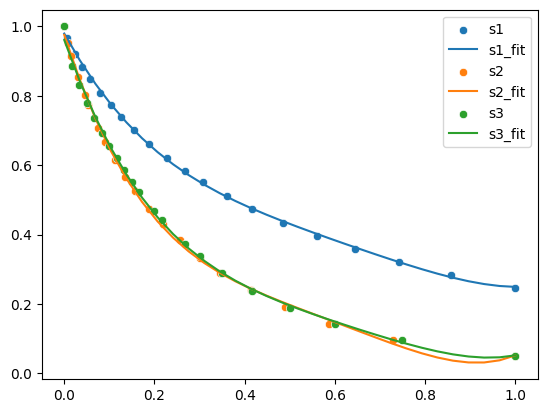

In [17]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, plot_fit_str='s1', verbose=True)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, plot_fit_str='s2', verbose=True)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, plot_fit_str='s3', verbose=True)

In [18]:
# featurize

df_case_3_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_3_rxn_1': {'s': s_conc_point_1},
        'case_3_rxn_2': {'s': s_conc_point_2},
        'case_3_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)

df_case_3_raw_data = conc_points2raw_data(
    conc_points = {
        'case_3_rxn_1': {'s': s_conc_point_1},
        'case_3_rxn_2': {'s': s_conc_point_2},
        'case_3_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)
df_case_3_data = pd.merge(df_case_3_tsfresh_data, df_case_3_raw_data, on='id')
df_case_3_data

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 108.31it/s]


id  s__variance_larger_than_standard_deviation  \
0  case_3_rxn_1                                         0.0   
1  case_3_rxn_2                                         0.0   
2  case_3_rxn_3                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0      14.459058       8.189854            0.025191       -0.025191   
1       8.301542       4.210378            0.033274       -0.031877   
2       8.491295       4.265584            0.031799       -0.031365   

   s__mean_second_derivative_central  ...       s20       s21       s22  \
0                           0.001329  ...  0.343177  0.328258  0.313802   
1                           0.002567  ...  0.103512  0.087088  0.071507   
2                           0.002219  ...   0.11155   0.09803  0.085221   

        s23       s24       s25       s26       s27       s28       s29  
0  0.299997  0.287092  0.275396  0.265279   0.25717  0.251558  0.248992  
1  0.057337  0.045283   0.03619  0.031044  0.030969  0.037232  0.051235  
2  0.073404  0.062958  0.054359  0.048184  0.045102  0.045883  0.051396  

[3 rows x 836 columns]

In [19]:
# predict

case_3_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_case_3_data)
case_3_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_case_3_data)
case_3_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_case_3_data)

In [20]:
df_case_3_pred_results = pd.DataFrame({
    'id': df_case_3_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_3_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_3_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_3_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_3_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_3_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_3_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_3_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_3_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_3_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_3_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_3_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_3_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_3_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_3_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_3_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_3_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_3_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_3_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_3_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  case_3_rxn_1            second                 0.860003              mm_2   
1  case_3_rxn_2          mm_1_out                 0.572124              mm_2   
2  case_3_rxn_3          mm_1_out                 0.644302              mm_2   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.068987             first                 0.023034   
1                 0.140055              zero                 0.133762   
2                 0.131583              zero                 0.077266   

  higher_cat_pred_1st  higher_cat_pred_1st_proba higher_cat_pred_2nd  \
0                mm_2                   0.396031              second   
1                mm_2                   0.387649              second   
2                mm_2                   0.398815              second   

   higher_cat_pred_2nd_proba higher_cat_pred_3rd  higher_cat_pred_3rd_proba  \
0                   0.228204               first                   0.132083   
1                   0.234250               first                   0.138697   
2                   0.227459               first                   0.136578   

  lower_cat_pred_1st  lower_cat_pred_1st_proba lower_cat_pred_2nd  \
0             second                  0.837396               mm_2   
1           mm_1_out                  0.527999               mm_2   
2           mm_1_out                  0.600517               mm_2   

   lower_cat_pred_2nd_proba lower_cat_pred_3rd  lower_cat_pred_3rd_proba  
0                  0.062908              first                  0.032214  
1                  0.200859             second                  0.122466  
2                  0.196235             second                  0.079330

In [21]:
case_3_rxn_1_cat_eq = df_case_3['catT'].dropna().values[0] / df_case_3['S'].dropna().values[0]
print(f'catalyst eq. of case_3 rxn_1: {case_3_rxn_1_cat_eq:.5f}')
case_3_rxn_2_cat_eq = df_case_3['catT.1'].dropna().values[0] / df_case_3['S.1'].dropna().values[0]
print(f'catalyst eq. of case_3 rxn_2: {case_3_rxn_2_cat_eq:.5f}')
case_3_rxn_3_cat_eq = df_case_3['catT.2'].dropna().values[0] / df_case_3['S.2'].dropna().values[0]
print(f'catalyst eq. of case_3 rxn_3: {case_3_rxn_3_cat_eq:.5f}')
print('======================')
print(f'case_3 rxn_1 prefers to {judege_cat_eq(case_3_rxn_1_cat_eq)}')
print(f'case_3 rxn_2 prefers to {judege_cat_eq(case_3_rxn_2_cat_eq)}')
print(f'case_3 rxn_3 prefers to {judege_cat_eq(case_3_rxn_3_cat_eq)}')

catalyst eq. of case_3 rxn_1: 0.00252
catalyst eq. of case_3 rxn_2: 0.00501
catalyst eq. of case_3 rxn_3: 0.01002
case_3 rxn_1 prefers to lower_cat
case_3 rxn_2 prefers to norm_cat
case_3 rxn_3 prefers to norm_cat


In [22]:
df_case_3_pred_results[['id'] + [c for c in df_case_3_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_3_rxn_1            second                 0.860003   
1  case_3_rxn_2          mm_1_out                 0.572124   
2  case_3_rxn_3          mm_1_out                 0.644302   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.396031             second   
1                mm_2                   0.387649           mm_1_out   
2                mm_2                   0.398815           mm_1_out   

   lower_cat_pred_1st_proba  
0                  0.837396  
1                  0.527999  
2                  0.600517

## Case 4

In [23]:
df_case_4 = pd.read_csv('./experiments/Kinetic_data_Case_study_4.txt', sep='\t')
df_case_4

time         S         P  catT  time.1         S.1         P.1  catT.1  \
0      0  447.2000    0.0000  4.48       0  447.200000    0.000000    6.72   
1     15  445.7024    1.4976  4.48      15  444.161608    3.038392    6.72   
2     30  441.2928    5.9072  4.48      30  438.555560    8.644440    6.72   
3     45  434.4288   12.7712  4.48      45  428.113761   19.086239    6.72   
4     60  423.3632   23.8368  4.48      60  412.451062   34.748938    6.72   
5     90  385.4656   61.7344  4.48      90  357.246469   89.953531    6.72   
6    120  321.5680  125.6320  4.48     120  271.144421  176.055579    6.72   
7    140  271.1904  176.0096  4.48     140  212.259522  234.940479    6.72   
8    160  221.7696  225.4304  4.48     160  161.762297  285.437703    6.72   
9    180  177.5904  269.6096  4.48     180  120.765397  326.434603    6.72   
10   210  124.9664  322.2336  4.48     210   79.468938  367.731062    6.72   
11   240   86.6528  360.5472  4.48     240   58.328574  388.871426    6.72   
12   270   63.1488  384.0512  4.48     270   50.711196  396.488804    6.72   
13   300   49.9200  397.2800  4.48     300   50.283254  396.916746    6.72   

    time.2         S.2         P.2  catT.2  time.3      S.3      P.3  catT.3  
0        0  447.200000    0.000000    8.96       0  223.600    0.000    4.48  
1       15  443.556148    3.643852    8.96      30  220.590    3.010    4.48  
2       30  436.144222   11.055778    8.96      45  218.440    5.160    4.48  
3       45  423.266519   23.933481    8.96      60  215.301    8.299    4.48  
4       60  404.177704   43.022296    8.96     120  191.694   31.906    4.48  
5       90  334.571852  112.628148    8.96     140  178.837   44.763    4.48  
6      120  233.744815  213.455185    8.96     160  162.454   61.146    4.48  
7      140  172.337630  274.862370    8.96     180  143.534   80.066    4.48  
8      160  126.044148  321.155852    8.96     210  113.821  109.779    4.48  
9      180   93.373704  353.826296    8.96     240   85.011  138.589    4.48  
10     210   66.541704  380.658296    8.96     270   62.479  161.121    4.48  
11     240   58.260222  388.939778    8.96     300   45.709  177.891    4.48  
12     270   56.645333  390.554667    8.96     330   34.572  189.028    4.48  
13     300   56.645333  390.554667    8.96     390   25.198  198.402    4.48

In [24]:
# S and P
sp_mode = 'sp'

time_1 = normalize(df_case_4['time'].dropna().values)
s_conc_1 = df_case_4['S'].dropna().values/df_case_4['S'].dropna().values[0]
p_conc_1 = df_case_4['P'].dropna().values/df_case_4['S'].dropna().values[0]

time_2 = normalize(df_case_4['time.1'].dropna().values)
s_conc_2 = df_case_4['S.1'].dropna().values/df_case_4['S.1'].dropna().values[0]
p_conc_2 = df_case_4['P.1'].dropna().values/df_case_4['S.1'].dropna().values[0]

time_3 = normalize(df_case_4['time.2'].dropna().values)
s_conc_3 = df_case_4['S.2'].dropna().values/df_case_4['S.2'].dropna().values[0]
p_conc_3 = df_case_4['P.2'].dropna().values/df_case_4['S.2'].dropna().values[0]

In [25]:
if is_quick_rxn(time_1, p_conc_1, obj='p') or is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, p_conc_1 = cut_rxn_time(time_1, p_conc_1, obj='p')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
    if p_conc_1.shape[0] != s_conc_1.shape[0]:
        raise ValueError('cutting rxn time error with rxn_1')
else:
    print('time_1 is fine')
if is_completed_rxn(p_conc_1, obj='p') or is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, p_conc_2, obj='p') or is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, p_conc_2 = cut_rxn_time(time_2, p_conc_2, obj='p')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
    if p_conc_2.shape[0] != s_conc_2.shape[0]:
        raise ValueError('cutting rxn time error with rxn_2')
else:
    print('time_2 is fine')
if is_completed_rxn(p_conc_2, obj='p') or is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, p_conc_3, obj='p') or is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, p_conc_3 = cut_rxn_time(time_3, p_conc_3, obj='p')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
    if p_conc_3.shape[0] != s_conc_3.shape[0]:
        raise ValueError('cutting rxn time error with rxn_3')
else:
    print('time_3 is fine')
if is_completed_rxn(p_conc_3, obj='p') or is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_1 is completed
time_2 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_2 is completed
time_3 is fine
NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn
rxn_3 is completed


In [26]:
s_conc_1 = cut_catalyst_init_rxn_time(time_1, s_conc_1, obj='s')
s_conc_1 = s_conc_1 / s_conc_1[0]
# p_conc_1 = cut_catalyst_init_rxn_time(time_1, p_conc_1, obj='p')
# p_conc_1 = p_conc_1 / s_conc_1[0]
p_conc_1 = 1 - s_conc_1
# assert s_conc_1.shape[0] == p_conc_1.shape[0]
time_1 = normalize(time_1[(time_1.shape[0] - s_conc_1.shape[0]):])

s_conc_2 = cut_catalyst_init_rxn_time(time_2, s_conc_2, obj='s')
s_conc_2 = s_conc_2 / s_conc_2[0]
# p_conc_2 = cut_catalyst_init_rxn_time(time_2, p_conc_2, obj='p')
# p_conc_2 = p_conc_2 / s_conc_2[0]
p_conc_2 = 1 - s_conc_2
# assert s_conc_2.shape[0] == p_conc_2.shape[0]
time_2 = normalize(time_2[(time_2.shape[0] - s_conc_2.shape[0]):])

s_conc_3 = cut_catalyst_init_rxn_time(time_3, s_conc_3, obj='s')
s_conc_3 = s_conc_3 / s_conc_3[0]
# p_conc_3 = cut_catalyst_init_rxn_time(time_3, p_conc_3, obj='p')
# p_conc_3 = p_conc_3 / s_conc_3[0]
p_conc_3 = 1 - s_conc_3
# assert s_conc_3.shape[0] == p_conc_3.shape[0]
time_3 = normalize(time_3[(time_3.shape[0] - s_conc_3.shape[0]):])

best degree: 6
best mse: 8.255315797608853e-08
best degree: 6
best mse: 8.255315797612056e-08
best degree: 6
best mse: 6.864258516108078e-08
best degree: 6
best mse: 6.864258516107604e-08
best degree: 6
best mse: 6.581058327437928e-07
best degree: 6
best mse: 6.581058327440899e-07


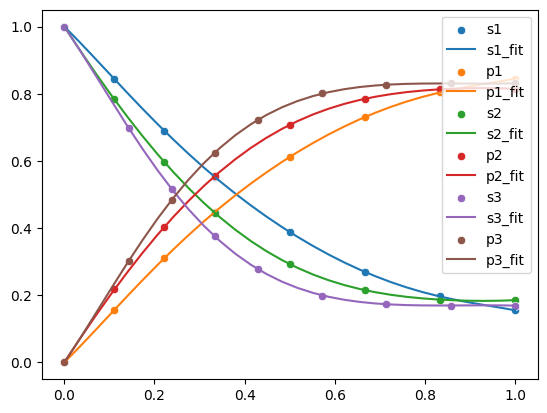

In [27]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=6, plot_fit_str='s1', verbose=True)
time_point_1_, p_conc_point_1 = generate_time_conc_curve(time_1, p_conc_1, max_degree=6, plot_fit_str='p1', verbose=True)
assert np.all(time_point_1 == time_point_1_)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=6, plot_fit_str='s2', verbose=True)
time_point_2_, p_conc_point_2 = generate_time_conc_curve(time_2, p_conc_2, max_degree=6, plot_fit_str='p2', verbose=True)
assert np.all(time_point_2 == time_point_2_)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=6, plot_fit_str='s3', verbose=True)
time_point_3_, p_conc_point_3 = generate_time_conc_curve(time_3, p_conc_3, max_degree=6, plot_fit_str='p3', verbose=True)
assert np.all(time_point_3 == time_point_3_)

In [28]:
# featurize

df_case_4_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_4_rxn_1': {'s': s_conc_point_1, 'p': p_conc_point_1},
        'case_4_rxn_2': {'s': s_conc_point_2, 'p': p_conc_point_2},
        'case_4_rxn_3': {'s': s_conc_point_3, 'p': p_conc_point_3}
    },
    sp_mode = sp_mode
)

df_case_4_raw_data = conc_points2raw_data(
    conc_points = {
        'case_4_rxn_1': {'s': s_conc_point_1, 'p': p_conc_point_1},
        'case_4_rxn_2': {'s': s_conc_point_2, 'p': p_conc_point_2},
        'case_4_rxn_3': {'s': s_conc_point_3, 'p': p_conc_point_3}
    },
    sp_mode = sp_mode
)
df_case_4_data = pd.merge(df_case_4_tsfresh_data, df_case_4_raw_data, on='id')
df_case_4_data

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 176.01it/s]


id  s__variance_larger_than_standard_deviation  \
0  case_4_rxn_1                                         0.0   
1  case_4_rxn_2                                         0.0   
2  case_4_rxn_3                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0      13.795309       8.388287            0.029128       -0.029128   
1      12.147565       6.788841            0.028236       -0.028087   
2      11.035904       6.012742            0.028686       -0.028648   

   s__mean_second_derivative_central  ...       p20       p21       p22  \
0                           0.000693  ...  0.743181   0.76074  0.776333   
1                           0.001280  ...  0.790908  0.798583  0.804595   
2                           0.001246  ...  0.824383  0.827405  0.829232   

        p23       p24       p25       p26       p27       p28       p29  
0  0.790004  0.801857  0.812079   0.82096  0.828932  0.836594  0.844755  
1  0.809185  0.812559   0.81488  0.816253   0.81671  0.816195  0.814546  
2  0.830164  0.830465  0.830375  0.830117   0.82992  0.830029  0.830736  

[3 rows x 1671 columns]

In [29]:
# predict
case_4_norm_cat_proba = ag_model_norm_cat_sp.predict_proba(df_case_4_data)
case_4_higher_cat_proba = ag_model_higher_cat_sp.predict_proba(df_case_4_data)
case_4_lower_cat_proba = ag_model_lower_cat_sp.predict_proba(df_case_4_data)

In [30]:
df_case_4_pred_results = pd.DataFrame({
    'id': df_case_4_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_4_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_4_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_4_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_4_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_4_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_4_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_4_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_4_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_4_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_4_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_4_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_4_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_4_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_4_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_4_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_4_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_4_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_4_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_4_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  case_4_rxn_1              mm_1                 0.695906             first   
1  case_4_rxn_2          mm_1_out                 0.627784             first   
2  case_4_rxn_3          mm_1_out                 0.687931             first   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.065000              mm_2                 0.062926   
1                 0.131311              mm_2                 0.064363   
2                 0.078965              mm_2                 0.063547   

  higher_cat_pred_1st  higher_cat_pred_1st_proba higher_cat_pred_2nd  \
0                mm_2                   0.953068              second   
1                mm_2                   0.929356               first   
2                mm_2                   0.856576            mm_1_out   

   higher_cat_pred_2nd_proba higher_cat_pred_3rd  higher_cat_pred_3rd_proba  \
0                   0.022352               first                   0.016624   
1                   0.026791              second                   0.023547   
2                   0.057934               first                   0.057653   

  lower_cat_pred_1st  lower_cat_pred_1st_proba lower_cat_pred_2nd  \
0               mm_1                  0.865911           mm_1_out   
1           mm_1_out                  0.808450              first   
2           mm_1_out                  0.919863              first   

   lower_cat_pred_2nd_proba lower_cat_pred_3rd  lower_cat_pred_3rd_proba  
0                  0.082430              first                  0.013614  
1                  0.134464               zero                  0.014687  
2                  0.028766               zero                  0.013249

In [31]:
case_4_rxn_1_cat_eq = df_case_4['catT'].dropna().values[0] / df_case_4['S'].dropna().values[0]
print(f'catalyst eq. of case_4 rxn_1: {case_4_rxn_1_cat_eq:.5f}')
case_4_rxn_2_cat_eq = df_case_4['catT.1'].dropna().values[0] / df_case_4['S.1'].dropna().values[0]
print(f'catalyst eq. of case_4 rxn_2: {case_4_rxn_2_cat_eq:.5f}')
case_4_rxn_3_cat_eq = df_case_4['catT.2'].dropna().values[0] / df_case_4['S.2'].dropna().values[0]
print(f'catalyst eq. of case_4 rxn_3: {case_4_rxn_3_cat_eq:.5f}')
print('======================')
print(f'case_4 rxn_1 prefers to {judege_cat_eq(case_4_rxn_1_cat_eq)}')
print(f'case_4 rxn_2 prefers to {judege_cat_eq(case_4_rxn_2_cat_eq)}')
print(f'case_4 rxn_3 prefers to {judege_cat_eq(case_4_rxn_3_cat_eq)}')

catalyst eq. of case_4 rxn_1: 0.01002
catalyst eq. of case_4 rxn_2: 0.01503
catalyst eq. of case_4 rxn_3: 0.02004
case_4 rxn_1 prefers to norm_cat
case_4 rxn_2 prefers to norm_cat
case_4 rxn_3 prefers to norm_cat


In [32]:
df_case_4_pred_results[['id'] + [c for c in df_case_4_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_4_rxn_1              mm_1                 0.695906   
1  case_4_rxn_2          mm_1_out                 0.627784   
2  case_4_rxn_3          mm_1_out                 0.687931   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.953068               mm_1   
1                mm_2                   0.929356           mm_1_out   
2                mm_2                   0.856576           mm_1_out   

   lower_cat_pred_1st_proba  
0                  0.865911  
1                  0.808450  
2                  0.919863

## Case 5

In [33]:
df_case_5 = pd.read_csv('./experiments/Kinetic_data_Case_study_5.txt', sep='\t')
df_case_5

time         S     catT    time.1       S.1  catT.1    time.2  \
0   0.000000  0.600000  0.00225  0.000000  0.600000   0.009  0.000000   
1   0.251267  0.571961  0.00225  0.191378  0.584317   0.009  0.231312   
2   0.331661  0.553279  0.00225  0.271266  0.563628   0.009  0.311573   
3   0.412063  0.538745  0.00225  0.351821  0.540778   0.009  0.411949   
4   0.572886  0.505528  0.00225  0.431420  0.515866   0.009  0.492523   
5   0.653273  0.486843  0.00225  0.512781  0.488901   0.009  0.572872   
6   0.733672  0.468158  0.00225  0.593000  0.459861   0.009  0.653334   
7   0.914576  0.434941  0.00225  0.653348  0.432841   0.009  0.733751   
8   0.994974  0.418333  0.00225  0.733629  0.405855   0.009  0.834239   
9   1.155784  0.385114  0.00225  0.834084  0.378861   0.009  0.914594   
10  1.236187  0.370582  0.00225  0.914187  0.351964   0.009  0.994927   
11  1.316589  0.341516  0.00225  0.994877  0.326955   0.009  1.075429   
12  1.497495  0.318679  0.00225  1.075238  0.302044   0.009  1.155756   
13  1.577901  0.304147  0.00225  1.155697  0.279204   0.009  1.236388   
14  1.738700  0.279233  0.00225  1.236143  0.258438   0.009  1.316667   
15  1.899510  0.256396  0.00225  1.316567  0.237666   0.009  1.417144   
16  2.080412  0.235635  0.00225  1.417213  0.216837   0.009  1.497482   
17  2.241214  0.208646  0.00225  1.497752  0.198166   0.009  1.577817   
18  2.482415  0.183734  0.00225  1.577568  0.181544   0.009  1.658276   
19  2.743725  0.160896  0.00225  1.658210  0.166841   0.009  1.738691   
20  3.065323  0.138055  0.00225  1.740212  0.152556   0.009  1.819077   
21  3.407056  0.117298  0.00225  1.820450  0.135814   0.009  1.899482   
22  3.909538  0.094458  0.00225  1.900688  0.123349   0.009  2.000208   
23  4.653299  0.069547  0.00225  2.002088  0.114887   0.009  2.080666   
24  5.658316  0.046711  0.00225  2.082327  0.104514   0.009  2.160745   
25  7.989968  0.023874  0.00225  2.243685  0.086134   0.009  2.241327   

         S.2  catT.2    time.3       S.3   catT.3  Unnamed: 12  Unnamed: 13  \
0   0.600000   0.018  0.000000  0.300000  0.00225          NaN          NaN   
1   0.547030   0.018  0.171874  0.286324      NaN          NaN          NaN   
2   0.505516   0.018  0.252682  0.277902  0.00225          NaN          NaN   
3   0.466070   0.018  0.333600  0.265272  0.00225          NaN          NaN   
4   0.422473   0.018  0.414312  0.250534  0.00225          NaN          NaN   
5   0.380975   0.018  0.495098  0.235798  0.00225          NaN          NaN   
6   0.339456   0.018  0.575910  0.221062  0.00225          NaN          NaN   
7   0.299998   0.018  0.656693  0.206326  0.00225          NaN          NaN   
8   0.262641   0.018  0.737447  0.191594  0.00225          NaN          NaN   
9   0.229406   0.018  0.818263  0.178961  0.00225          NaN          NaN   
10  0.198274   0.018  0.919333  0.164235  0.00225          NaN          NaN   
11  0.169217   0.018  1.000135  0.153692  0.00225          NaN          NaN   
12  0.144299   0.018  1.080951  0.141066  0.00225          NaN          NaN   
13  0.123530   0.018  1.161773  0.130539  0.00225          NaN          NaN   
14  0.102762   0.018  1.242560  0.120013  0.00225          NaN          NaN   
15  0.088242   0.018  1.323361  0.111590  0.00225          NaN          NaN   
16  0.073717   0.018  1.404174  0.103170  0.00225          NaN          NaN   
17  0.061250   0.018  1.485090  0.094747  0.00225          NaN          NaN   
18  0.050874   0.018  1.585935  0.088435  0.00225          NaN          NaN   
19  0.042571   0.018  1.666789  0.082114  0.00225          NaN          NaN   
20  0.036326   0.018  1.747608  0.075799  0.00225          NaN          NaN   
21  0.030106   0.018  1.909214  0.063172  0.00225          NaN          NaN   
22  0.025930   0.018  2.070842  0.054744  0.00225          NaN          NaN   
23  0.021785   0.018  2.333429  0.044220  0.00225          NaN          NaN   
24  0.019725   0.018  2.737461  0.031598  0.00225          Na

In [34]:
# only S
sp_mode = 's'

time_1 = normalize(df_case_5['time'].dropna().values)
s_conc_1 = df_case_5['S'].dropna().values/df_case_5['S'].dropna().values[0]

time_2 = normalize(df_case_5['time.1'].dropna().values)
s_conc_2 = df_case_5['S.1'].dropna().values/df_case_5['S.1'].dropna().values[0]

time_3 = normalize(df_case_5['time.2'].dropna().values)
s_conc_3 = df_case_5['S.2'].dropna().values/df_case_5['S.2'].dropna().values[0]

time_4 = normalize(df_case_5['time.3'].dropna().values)
s_conc_4 = df_case_5['S.3'].dropna().values/df_case_5['S.3'].dropna().values[0]


In [35]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

print('====================')

if is_quick_rxn(time_4, s_conc_4, obj='s'):
    print('need to cut time_4')
    time_4, s_conc_4 = cut_rxn_time(time_4, s_conc_4, obj='s')
else:
    print('time_4 is fine')
if is_completed_rxn(s_conc_4, obj='s'):
    print('rxn_4 is completed')
else:
    print('rxn_4 may be not completed')

time_1 is fine
rxn_1 is completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed
time_4 is fine
rxn_4 is completed


best degree: 3
best mse: 0.0002397261125027813
best degree: 5
best mse: 1.2478614958316821e-05
best degree: 5
best mse: 1.3104260220099975e-05
best degree: 7
best mse: 7.977882161419908e-06


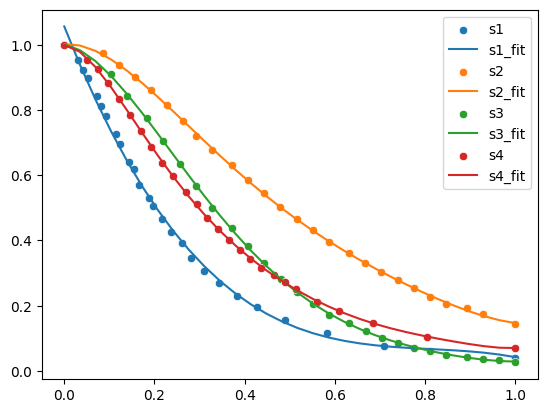

In [36]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=3, plot_fit_str='s1', verbose=True)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=5, plot_fit_str='s2', verbose=True)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=5, plot_fit_str='s3', verbose=True)
time_point_4, s_conc_point_4 = generate_time_conc_curve(time_4, s_conc_4, max_degree=7, plot_fit_str='s4', verbose=True)

In [37]:
# featurize

df_case_5_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_5_rxn_1': {'s': s_conc_point_1},
        'case_5_rxn_2': {'s': s_conc_point_2},
        'case_5_rxn_3': {'s': s_conc_point_3},
        'case_5_rxn_4': {'s': s_conc_point_4}
    },
    sp_mode = sp_mode
)

df_case_5_raw_data = conc_points2raw_data(
    conc_points = {
        'case_5_rxn_1': {'s': s_conc_point_1},
        'case_5_rxn_2': {'s': s_conc_point_2},
        'case_5_rxn_3': {'s': s_conc_point_3},
        'case_5_rxn_4': {'s': s_conc_point_4}
    },
    sp_mode = sp_mode
)
df_case_5_data = pd.merge(df_case_5_tsfresh_data, df_case_5_raw_data, on='id')
df_case_5_data

Feature Extraction: 100%|██████████| 4/4 [00:00<00:00, 138.62it/s]


id  s__variance_larger_than_standard_deviation  \
0  case_5_rxn_1                                         0.0   
1  case_5_rxn_2                                         0.0   
2  case_5_rxn_3                                         0.0   
3  case_5_rxn_4                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   
3                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0       8.599160       4.970552            0.034952       -0.034952   
1      15.908535      10.907955            0.029490       -0.029490   
2      11.368094       7.594930            0.033541       -0.033541   
3      11.323674       7.002143            0.032029       -0.032029   

   s__mean_second_derivative_central  ...       s20       s21       s22  \
0                           0.001940  ...  0.078642   0.07428  0.071005   
1                          -0.000082  ...   0.31406  0.288934  0.265079   
2                           0.000290  ...  0.109657  0.093291  0.079225   
3                           0.000352  ...  0.144101  0.130701  0.119008   

        s23       s24       s25       s26       s27       s28       s29  
0  0.068389     0.066  0.063409  0.060187  0.055903  0.050129  0.042433  
1  0.242479  0.221212   0.20147  0.183576  0.168014   0.15544  0.146713  
2  0.067112  0.056679  0.047752  0.040288  0.034397  0.030367  0.028694  
3  0.108659  0.099305  0.090692  0.082788  0.075952  0.071164  0.070311  

[4 rows x 836 columns]

In [38]:
# predict
case_5_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_case_5_data)
case_5_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_case_5_data)
case_5_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_case_5_data)

In [39]:
df_case_5_pred_results = pd.DataFrame({
    'id': df_case_5_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_5_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_5_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_5_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_5_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_5_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_5_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_5_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_5_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_5_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_5_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_5_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_5_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_5_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_5_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_5_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_5_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_5_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_5_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_5_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba norm_cat_pred_2nd  \
0  case_5_rxn_1          mm_1_out                 0.860265              mm_1   
1  case_5_rxn_2              mm_1                 0.673313              zero   
2  case_5_rxn_3              mm_1                 0.844424             first   
3  case_5_rxn_4              mm_1                 0.550257             first   

   norm_cat_pred_2nd_proba norm_cat_pred_3rd  norm_cat_pred_3rd_proba  \
0                 0.053756            second                 0.021693   
1                 0.162815             first                 0.052764   
2                 0.039488          mm_1_out                 0.030072   
3                 0.229916          mm_1_out                 0.074839   

  higher_cat_pred_1st  higher_cat_pred_1st_proba higher_cat_pred_2nd  \
0                mm_2                   0.316998              second   
1                mm_2                   0.360551              second   
2                mm_2                   0.333181              second   
3                mm_2                   0.340855              second   

   higher_cat_pred_2nd_proba higher_cat_pred_3rd  higher_cat_pred_3rd_proba  \
0                   0.251264               first                   0.183875   
1                   0.231358               first                   0.151069   
2                   0.250694               first                   0.161643   
3                   0.237270               first                   0.168647   

  lower_cat_pred_1st  lower_cat_pred_1st_proba lower_cat_pred_2nd  \
0           mm_1_out                  0.602987               mm_1   
1               mm_1                  0.703500               zero   
2               mm_1                  0.789120              first   
3               mm_1                  0.492969              first   

   lower_cat_pred_2nd_proba lower_cat_pred_3rd  lower_cat_pred_3rd_proba  
0                  0.267025             second                  0.032836  
1                  0.139131              first                  0.044994  
2                  0.044146               zero                  0.043473  
3                  0.203586           mm_1_out                  0.146293

In [40]:
case_5_rxn_1_cat_eq = df_case_5['catT'].dropna().values[0] / df_case_5['S'].dropna().values[0]
print(f'catalyst eq. of case_5 rxn_1: {case_5_rxn_1_cat_eq:.5f}')
case_5_rxn_2_cat_eq = df_case_5['catT.1'].dropna().values[0] / df_case_5['S.1'].dropna().values[0]
print(f'catalyst eq. of case_5 rxn_2: {case_5_rxn_2_cat_eq:.5f}')
case_5_rxn_3_cat_eq = df_case_5['catT.2'].dropna().values[0] / df_case_5['S.2'].dropna().values[0]
print(f'catalyst eq. of case_5 rxn_3: {case_5_rxn_3_cat_eq:.5f}')
case_5_rxn_4_cat_eq = df_case_5['catT.3'].dropna().values[0] / df_case_5['S.3'].dropna().values[0]
print(f'catalyst eq. of case_5 rxn_4: {case_5_rxn_4_cat_eq:.5f}')
print('======================')
print(f'case_5 rxn_1 prefers to {judege_cat_eq(case_5_rxn_1_cat_eq)}')
print(f'case_5 rxn_2 prefers to {judege_cat_eq(case_5_rxn_2_cat_eq)}')
print(f'case_5 rxn_3 prefers to {judege_cat_eq(case_5_rxn_3_cat_eq)}')
print(f'case_5 rxn_4 prefers to {judege_cat_eq(case_5_rxn_4_cat_eq)}')

catalyst eq. of case_5 rxn_1: 0.00375
catalyst eq. of case_5 rxn_2: 0.01500
catalyst eq. of case_5 rxn_3: 0.03000
catalyst eq. of case_5 rxn_4: 0.00750
case_5 rxn_1 prefers to norm_cat
case_5 rxn_2 prefers to norm_cat
case_5 rxn_3 prefers to norm_cat
case_5 rxn_4 prefers to norm_cat


In [41]:
df_case_5_pred_results[['id'] + [c for c in df_case_5_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_5_rxn_1          mm_1_out                 0.860265   
1  case_5_rxn_2              mm_1                 0.673313   
2  case_5_rxn_3              mm_1                 0.844424   
3  case_5_rxn_4              mm_1                 0.550257   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.316998           mm_1_out   
1                mm_2                   0.360551               mm_1   
2                mm_2                   0.333181               mm_1   
3                mm_2                   0.340855               mm_1   

   lower_cat_pred_1st_proba  
0                  0.602987  
1                  0.703500  
2                  0.789120  
3                  0.492969

## Case 6 Me

In [42]:
df_case_6_Me = pd.read_csv('./experiments/Kinetic_data_Case_study_6_Me.txt', sep='\t')
df_case_6_Me

time         S     catT  time.1       S.1    catT.1  time.2       S.2  \
0      0  0.001000  0.00005       0  0.001000  0.000075       0  0.001000   
1     60  0.000850  0.00005      60  0.000798  0.000075      60  0.000746   
2    120  0.000790  0.00005     120  0.000740  0.000075     120  0.000680   
3    180  0.000768  0.00005     180  0.000685  0.000075     180  0.000597   
4    240  0.000750  0.00005     240  0.000637  0.000075     240  0.000524   
5    300  0.000727  0.00005     300  0.000601  0.000075     300  0.000485   
6    360  0.000698  0.00005     360  0.000556  0.000075     360  0.000434   
7    420  0.000671  0.00005     420  0.000527  0.000075     420  0.000404   
8    480  0.000657  0.00005     480  0.000494  0.000075     480  0.000377   
9    540  0.000654  0.00005     540  0.000471  0.000075     540  0.000349   
10   600  0.000628  0.00005     600  0.000456  0.000075     600  0.000327   
11   660  0.000612  0.00005     660  0.000444  0.000075     660  0.000309   
12   720  0.000597  0.00005     720  0.000438  0.000075     720  0.000302   
13   780  0.000584  0.00005     780  0.000427  0.000075     780  0.000301   
14   840  0.000576  0.00005     840  0.000410  0.000075     840  0.000288   

    catT.2  
0   0.0001  
1   0.0001  
2   0.0001  
3   0.0001  
4   0.0001  
5   0.0001  
6   0.0001  
7   0.0001  
8   0.0001  
9   0.0001  
10  0.0001  
11  0.0001  
12  0.0001  
13  0.0001  
14  0.0001

In [43]:
# only S
sp_mode = 's'

time_1 = normalize(df_case_6_Me['time'].dropna().values)
s_conc_1 = df_case_6_Me['S'].dropna().values/df_case_6_Me['S'].dropna().values[0]

time_2 = normalize(df_case_6_Me['time.1'].dropna().values)
s_conc_2 = df_case_6_Me['S.1'].dropna().values/df_case_6_Me['S.1'].dropna().values[0]

time_3 = normalize(df_case_6_Me['time.2'].dropna().values)
s_conc_3 = df_case_6_Me['S.2'].dropna().values/df_case_6_Me['S.2'].dropna().values[0]

In [44]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
rxn_1 may be not completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed


best degree: 6
best mse: 1.5945879177570993e-05
best degree: 6
best mse: 3.6414915635997904e-05
best degree: 6
best mse: 0.00012255593130634988


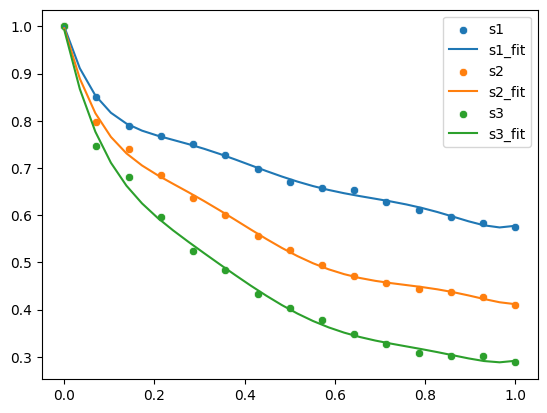

In [45]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=6, plot_fit_str='s1', verbose=True)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=6, plot_fit_str='s2', verbose=True)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=6, plot_fit_str='s3', verbose=True)

In [46]:
# featurize

df_case_6_Me_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_6_Me_rxn_1': {'s': s_conc_point_1},
        'case_6_Me_rxn_2': {'s': s_conc_point_2},
        'case_6_Me_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)

df_case_6_Me_raw_data = conc_points2raw_data(
    conc_points = {
        'case_6_Me_rxn_1': {'s': s_conc_point_1},
        'case_6_Me_rxn_2': {'s': s_conc_point_2},
        'case_6_Me_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)
df_case_6_Me_data = pd.merge(df_case_6_Me_tsfresh_data, df_case_6_Me_raw_data, on='id')
df_case_6_Me_data

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 115.97it/s]


id  s__variance_larger_than_standard_deviation  \
0  case_6_Me_rxn_1                                         0.0   
1  case_6_Me_rxn_2                                         0.0   
2  case_6_Me_rxn_3                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0      21.002096      15.014663            0.014788       -0.014549   
1      17.200933      10.538191            0.020158       -0.020158   
2      14.024916       7.562189            0.024404       -0.024185   

   s__mean_second_derivative_central  ...       s20       s21       s22  \
0                           0.001636  ...   0.63496  0.629237  0.622878   
1                           0.001832  ...  0.460995  0.456189  0.452038   
2                           0.002295  ...  0.334487  0.328019  0.322085   

        s23       s24       s25       s26       s27       s28       s29  
0  0.615455  0.606784  0.597084  0.587166   0.57864  0.574145  0.577613  
1  0.447843  0.442991   0.43708  0.430077  0.422493  0.415583   0.41157  
2   0.31617  0.309919  0.303274  0.296632  0.291028  0.288343  0.291524  

[3 rows x 836 columns]

In [47]:
# predict
case_6_Me_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_case_6_Me_data)
case_6_Me_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_case_6_Me_data)
case_6_Me_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_case_6_Me_data)

In [48]:
df_case_6_Me_pred_results = pd.DataFrame({
    'id': df_case_6_Me_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_6_Me_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_6_Me_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_6_Me_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_6_Me_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_6_Me_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_6_Me_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_6_Me_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_6_Me_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_6_Me_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_6_Me_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_6_Me_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_6_Me_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_6_Me_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_6_Me_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_6_Me_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_6_Me_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_6_Me_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_6_Me_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_6_Me_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_6_Me_rxn_1              mm_2                 0.735533   
1  case_6_Me_rxn_2              mm_2                 0.692034   
2  case_6_Me_rxn_3            second                 0.692530   

  norm_cat_pred_2nd  norm_cat_pred_2nd_proba norm_cat_pred_3rd  \
0            second                 0.158529              zero   
1            second                 0.199611             first   
2              mm_2                 0.236384              zero   

   norm_cat_pred_3rd_proba higher_cat_pred_1st  higher_cat_pred_1st_proba  \
0                 0.037260                mm_2                   0.393247   
1                 0.038084                mm_2                   0.404529   
2                 0.023107                mm_2                   0.402642   

  higher_cat_pred_2nd  higher_cat_pred_2nd_proba higher_cat_pred_3rd  \
0              second                   0.242885               first   
1              second                   0.241104               first   
2              second                   0.239069               first   

   higher_cat_pred_3rd_proba lower_cat_pred_1st  lower_cat_pred_1st_proba  \
0                   0.108905               mm_2                  0.577832   
1                   0.110581               mm_2                  0.526131   
2                   0.116266             second                  0.809583   

  lower_cat_pred_2nd  lower_cat_pred_2nd_proba lower_cat_pred_3rd  \
0             second                  0.271616               zero   
1             second                  0.328196              first   
2               mm_2                  0.088906              first   

   lower_cat_pred_3rd_proba  
0                  0.052145  
1                  0.049727  
2                  0.033058

In [49]:
case_6_Me_rxn_1_cat_eq = df_case_6_Me['catT'].dropna().values[0] / df_case_6_Me['S'].dropna().values[0]
print(f'catalyst eq. of case_6_Me rxn_1: {case_6_Me_rxn_1_cat_eq:.5f}')
case_6_Me_rxn_2_cat_eq = df_case_6_Me['catT.1'].dropna().values[0] / df_case_6_Me['S.1'].dropna().values[0]
print(f'catalyst eq. of case_6_Me rxn_2: {case_6_Me_rxn_2_cat_eq:.5f}')
case_6_Me_rxn_3_cat_eq = df_case_6_Me['catT.2'].dropna().values[0] / df_case_6_Me['S.2'].dropna().values[0]
print(f'catalyst eq. of case_6_Me rxn_3: {case_6_Me_rxn_3_cat_eq:.5f}')
print('======================')
print(f'case_6_Me rxn_1 prefers to {judege_cat_eq(case_6_Me_rxn_1_cat_eq)}')
print(f'case_6_Me rxn_2 prefers to {judege_cat_eq(case_6_Me_rxn_2_cat_eq)}')
print(f'case_6_Me rxn_3 prefers to {judege_cat_eq(case_6_Me_rxn_3_cat_eq)}')

catalyst eq. of case_6_Me rxn_1: 0.05000
catalyst eq. of case_6_Me rxn_2: 0.07500
catalyst eq. of case_6_Me rxn_3: 0.10000
case_6_Me rxn_1 prefers to higher_cat
case_6_Me rxn_2 prefers to higher_cat
case_6_Me rxn_3 prefers to higher_cat


In [50]:
df_case_6_Me_pred_results[['id'] + [c for c in df_case_6_Me_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_6_Me_rxn_1              mm_2                 0.735533   
1  case_6_Me_rxn_2              mm_2                 0.692034   
2  case_6_Me_rxn_3            second                 0.692530   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.393247               mm_2   
1                mm_2                   0.404529               mm_2   
2                mm_2                   0.402642             second   

   lower_cat_pred_1st_proba  
0                  0.577832  
1                  0.526131  
2                  0.809583

## Case 6 Ph

In [51]:
df_case_6_Ph = pd.read_csv('./experiments/Kinetic_data_Case_study_6_Ph.txt', sep='\t')
df_case_6_Ph

time         S     catT  time.1       S.1    catT.1  time.2       S.2  \
0      0  0.001000  0.00005       0  0.001000  0.000075       0  0.001000   
1     30  0.000841  0.00005      30  0.000755  0.000075      15  0.000788   
2     60  0.000745  0.00005      60  0.000632  0.000075      30  0.000657   
3     90  0.000665  0.00005      90  0.000503  0.000075      45  0.000566   
4    120  0.000597  0.00005     120  0.000395  0.000075      60  0.000501   
5    150  0.000528  0.00005     150  0.000316  0.000075      75  0.000424   
6    180  0.000488  0.00005     180  0.000256  0.000075      90  0.000375   
7    210  0.000456  0.00005     210  0.000219  0.000075     105  0.000324   
8    240  0.000418  0.00005     240  0.000196  0.000075     120  0.000294   
9    270  0.000377  0.00005     270  0.000181  0.000075     135  0.000256   
10   300  0.000355  0.00005     300  0.000162  0.000075     150  0.000232   
11   330  0.000334  0.00005     330  0.000152  0.000075     165  0.000212   
12   360  0.000315  0.00005     360  0.000139  0.000075     180  0.000188   
13   390  0.000296  0.00005     390  0.000129  0.000075     195  0.000166   
14   420  0.000285  0.00005     420  0.000114  0.000075     210  0.000146   
15   450  0.000268  0.00005     450  0.000103  0.000075     225  0.000124   
16   480  0.000254  0.00005     480  0.000093  0.000075     240  0.000108   
17   510  0.000238  0.00005     510  0.000083  0.000075     255  0.000099   
18   540  0.000233  0.00005     540  0.000072  0.000075     270  0.000086   
19   570  0.000220  0.00005     570  0.000065  0.000075     285  0.000080   
20   600  0.000211  0.00005     600  0.000055  0.000075     300  0.000069   
21   630  0.000200  0.00005     630  0.000048  0.000075     315  0.000059   
22   660  0.000190  0.00005     660  0.000044  0.000075     330  0.000051   
23   690  0.000182  0.00005     690  0.000042  0.000075     345  0.000041   
24   720  0.000174  0.00005     720  0.000041  0.000075     360  0.000037   

    catT.2  
0   0.0001  
1   0.0001  
2   0.0001  
3   0.0001  
4   0.0001  
5   0.0001  
6   0.0001  
7   0.0001  
8   0.0001  
9   0.0001  
10  0.0001  
11  0.0001  
12  0.0001  
13  0.0001  
14  0.0001  
15  0.0001  
16  0.0001  
17  0.0001  
18  0.0001  
19  0.0001  
20  0.0001  
21  0.0001  
22  0.0001  
23  0.0001  
24  0.0001

In [52]:
# only S
sp_mode = 's'

time_1 = normalize(df_case_6_Ph['time'].dropna().values)
s_conc_1 = df_case_6_Ph['S'].dropna().values/df_case_6_Ph['S'].dropna().values[0]

time_2 = normalize(df_case_6_Ph['time.1'].dropna().values)
s_conc_2 = df_case_6_Ph['S.1'].dropna().values/df_case_6_Ph['S.1'].dropna().values[0]

time_3 = normalize(df_case_6_Ph['time.2'].dropna().values)
s_conc_3 = df_case_6_Ph['S.2'].dropna().values/df_case_6_Ph['S.2'].dropna().values[0]

In [53]:
if is_quick_rxn(time_1, s_conc_1, obj='s'):
    print('need to cut time_1')
    time_1, s_conc_1 = cut_rxn_time(time_1, s_conc_1, obj='s')
else:
    print('time_1 is fine')
if is_completed_rxn(s_conc_1, obj='s'):
    print('rxn_1 is completed')
else:
    print('rxn_1 may be not completed')

print('====================')

if is_quick_rxn(time_2, s_conc_2, obj='s'):
    print('need to cut time_2')
    time_2, s_conc_2 = cut_rxn_time(time_2, s_conc_2, obj='s')
else:
    print('time_2 is fine')
if is_completed_rxn(s_conc_2, obj='s'):
    print('rxn_2 is completed')
else:
    print('rxn_2 may be not completed')

print('====================')

if is_quick_rxn(time_3, s_conc_3, obj='s'):
    print('need to cut time_3')
    time_3, s_conc_3 = cut_rxn_time(time_3, s_conc_3, obj='s')
else:
    print('time_3 is fine')
if is_completed_rxn(s_conc_3, obj='s'):
    print('rxn_3 is completed')
else:
    print('rxn_3 may be not completed')

time_1 is fine
rxn_1 is completed
time_2 is fine
rxn_2 is completed
time_3 is fine
rxn_3 is completed


best degree: 5
best mse: 2.903065765438897e-05
best degree: 5
best mse: 5.711867100296001e-05
best degree: 5
best mse: 5.79629062154206e-05


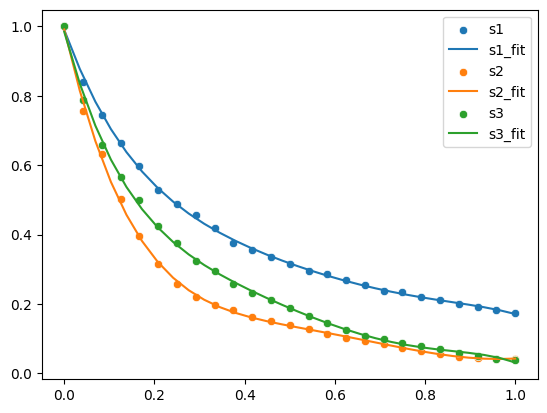

In [54]:
time_point_1, s_conc_point_1 = generate_time_conc_curve(time_1, s_conc_1, max_degree=5, plot_fit_str='s1', verbose=True)
time_point_2, s_conc_point_2 = generate_time_conc_curve(time_2, s_conc_2, max_degree=5, plot_fit_str='s2', verbose=True)
time_point_3, s_conc_point_3 = generate_time_conc_curve(time_3, s_conc_3, max_degree=5, plot_fit_str='s3', verbose=True)

In [55]:
# featurize

df_case_6_Ph_tsfresh_data = get_tsfresh_features(
    conc_points = {
        'case_6_Ph_rxn_1': {'s': s_conc_point_1},
        'case_6_Ph_rxn_2': {'s': s_conc_point_2},
        'case_6_Ph_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)

df_case_6_Ph_raw_data = conc_points2raw_data(
    conc_points = {
        'case_6_Ph_rxn_1': {'s': s_conc_point_1},
        'case_6_Ph_rxn_2': {'s': s_conc_point_2},
        'case_6_Ph_rxn_3': {'s': s_conc_point_3}
    },
    sp_mode = sp_mode
)
df_case_6_Ph_data = pd.merge(df_case_6_Ph_tsfresh_data, df_case_6_Ph_raw_data, on='id')
df_case_6_Ph_data

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 116.82it/s]


id  s__variance_larger_than_standard_deviation  \
0  case_6_Ph_rxn_1                                         0.0   
1  case_6_Ph_rxn_2                                         0.0   
2  case_6_Ph_rxn_3                                         0.0   

   s__has_duplicate_max  s__has_duplicate_min  s__has_duplicate  \
0                   0.0                   0.0               0.0   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               0.0   

   s__sum_values  s__abs_energy  s__mean_abs_change  s__mean_change  \
0      11.801124       6.032925            0.028241       -0.028241   
1       6.887092       3.273525            0.032809       -0.032726   
2       8.205469       4.052162            0.032873       -0.032873   

   s__mean_second_derivative_central  ...       s20       s21       s22  \
0                           0.001813  ...   0.24508  0.235393  0.226664   
1                           0.003177  ...  0.088953  0.079954   0.07122   
2                           0.002433  ...  0.101238  0.090585  0.081749   

        s23       s24       s25       s26       s27       s28       s29  
0   0.21878  0.211553  0.204699  0.197817  0.190373  0.181676  0.170859  
1  0.063036  0.055715  0.049577  0.044926  0.042035  0.041118  0.042318  
2  0.074598  0.068814  0.063852  0.058897  0.052827  0.044168  0.031057  

[3 rows x 836 columns]

In [56]:
# predict
case_6_Ph_norm_cat_proba = ag_model_norm_cat_s.predict_proba(df_case_6_Ph_data)
case_6_Ph_higher_cat_proba = ag_model_higher_cat_s.predict_proba(df_case_6_Ph_data)
case_6_Ph_lower_cat_proba = ag_model_lower_cat_s.predict_proba(df_case_6_Ph_data)

In [57]:
df_case_6_Ph_pred_results = pd.DataFrame({
    'id': df_case_6_Ph_data['id'],
    'norm_cat_pred_1st': get_top_x_probs(case_6_Ph_norm_cat_proba, x=1)['list_indices_1'],
    'norm_cat_pred_1st_proba': get_top_x_probs(case_6_Ph_norm_cat_proba, x=1)['list_probs_1'],
    'norm_cat_pred_2nd': get_top_x_probs(case_6_Ph_norm_cat_proba, x=2)['list_indices_2'],
    'norm_cat_pred_2nd_proba': get_top_x_probs(case_6_Ph_norm_cat_proba, x=2)['list_probs_2'],
    'norm_cat_pred_3rd': get_top_x_probs(case_6_Ph_norm_cat_proba, x=3)['list_indices_3'],
    'norm_cat_pred_3rd_proba': get_top_x_probs(case_6_Ph_norm_cat_proba, x=3)['list_probs_3'],
    'higher_cat_pred_1st': get_top_x_probs(case_6_Ph_higher_cat_proba, x=1)['list_indices_1'],
    'higher_cat_pred_1st_proba': get_top_x_probs(case_6_Ph_higher_cat_proba, x=1)['list_probs_1'],
    'higher_cat_pred_2nd': get_top_x_probs(case_6_Ph_higher_cat_proba, x=2)['list_indices_2'],
    'higher_cat_pred_2nd_proba': get_top_x_probs(case_6_Ph_higher_cat_proba, x=2)['list_probs_2'],
    'higher_cat_pred_3rd': get_top_x_probs(case_6_Ph_higher_cat_proba, x=3)['list_indices_3'],
    'higher_cat_pred_3rd_proba': get_top_x_probs(case_6_Ph_higher_cat_proba, x=3)['list_probs_3'],
    'lower_cat_pred_1st': get_top_x_probs(case_6_Ph_lower_cat_proba, x=1)['list_indices_1'],
    'lower_cat_pred_1st_proba': get_top_x_probs(case_6_Ph_lower_cat_proba, x=1)['list_probs_1'],
    'lower_cat_pred_2nd': get_top_x_probs(case_6_Ph_lower_cat_proba, x=2)['list_indices_2'],
    'lower_cat_pred_2nd_proba': get_top_x_probs(case_6_Ph_lower_cat_proba, x=2)['list_probs_2'],
    'lower_cat_pred_3rd': get_top_x_probs(case_6_Ph_lower_cat_proba, x=3)['list_indices_3'],
    'lower_cat_pred_3rd_proba': get_top_x_probs(case_6_Ph_lower_cat_proba, x=3)['list_probs_3'],
})
df_case_6_Ph_pred_results

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_6_Ph_rxn_1            second                 0.441271   
1  case_6_Ph_rxn_2          mm_1_out                 0.846863   
2  case_6_Ph_rxn_3          mm_1_out                 0.728164   

  norm_cat_pred_2nd  norm_cat_pred_2nd_proba norm_cat_pred_3rd  \
0              mm_2                 0.248046          mm_1_out   
1             first                 0.054910              zero   
2              zero                 0.108087              mm_2   

   norm_cat_pred_3rd_proba higher_cat_pred_1st  higher_cat_pred_1st_proba  \
0                 0.174610                mm_2                   0.443226   
1                 0.042076                mm_2                   0.442579   
2                 0.068749                mm_2                   0.427554   

  higher_cat_pred_2nd  higher_cat_pred_2nd_proba higher_cat_pred_3rd  \
0              second                   0.206554               first   
1              second                   0.195385               first   
2              second                   0.215116               first   

   higher_cat_pred_3rd_proba lower_cat_pred_1st  lower_cat_pred_1st_proba  \
0                   0.116558             second                  0.501549   
1                   0.133359           mm_1_out                  0.846140   
2                   0.123963           mm_1_out                  0.794396   

  lower_cat_pred_2nd  lower_cat_pred_2nd_proba lower_cat_pred_3rd  \
0               mm_2                  0.232109           mm_1_out   
1               zero                  0.038263               mm_2   
2               mm_2                  0.067408               zero   

   lower_cat_pred_3rd_proba  
0                  0.155944  
1                  0.036672  
2                  0.049199

In [58]:
case_6_Ph_rxn_1_cat_eq = df_case_6_Ph['catT'].dropna().values[0] / df_case_6_Ph['S'].dropna().values[0]
print(f'catalyst eq. of case_6_Ph rxn_1: {case_6_Ph_rxn_1_cat_eq:.5f}')
case_6_Ph_rxn_2_cat_eq = df_case_6_Ph['catT.1'].dropna().values[0] / df_case_6_Ph['S.1'].dropna().values[0]
print(f'catalyst eq. of case_6_Ph rxn_2: {case_6_Ph_rxn_2_cat_eq:.5f}')
case_6_Ph_rxn_3_cat_eq = df_case_6_Ph['catT.2'].dropna().values[0] / df_case_6_Ph['S.2'].dropna().values[0]
print(f'catalyst eq. of case_6_Ph rxn_3: {case_6_Ph_rxn_3_cat_eq:.5f}')
print('======================')
print(f'case_6_Ph rxn_1 prefers to {judege_cat_eq(case_6_Ph_rxn_1_cat_eq)}')
print(f'case_6_Ph rxn_2 prefers to {judege_cat_eq(case_6_Ph_rxn_2_cat_eq)}')
print(f'case_6_Ph rxn_3 prefers to {judege_cat_eq(case_6_Ph_rxn_3_cat_eq)}')

catalyst eq. of case_6_Ph rxn_1: 0.05000
catalyst eq. of case_6_Ph rxn_2: 0.07500
catalyst eq. of case_6_Ph rxn_3: 0.10000
case_6_Ph rxn_1 prefers to higher_cat
case_6_Ph rxn_2 prefers to higher_cat
case_6_Ph rxn_3 prefers to higher_cat


In [59]:
df_case_6_Ph_pred_results[['id'] + [c for c in df_case_6_Ph_pred_results.columns if '1st' in c]]

id norm_cat_pred_1st  norm_cat_pred_1st_proba  \
0  case_6_Ph_rxn_1            second                 0.441271   
1  case_6_Ph_rxn_2          mm_1_out                 0.846863   
2  case_6_Ph_rxn_3          mm_1_out                 0.728164   

  higher_cat_pred_1st  higher_cat_pred_1st_proba lower_cat_pred_1st  \
0                mm_2                   0.443226             second   
1                mm_2                   0.442579           mm_1_out   
2                mm_2                   0.427554           mm_1_out   

   lower_cat_pred_1st_proba  
0                  0.501549  
1                  0.846140  
2                  0.794396